In [1]:
import math
import time
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style

import glob

import os
os.environ['R_HOME'] = '/usr/lib/R'
os.chdir('/laune_zfs/scratch/peter/f_active/paper_23/') # laune

# import ot
# ot.backend.get_backend_list()

# import torch
# torch.cuda.is_available()

# from GraphST import GraphST
# from GraphST.utils import clustering
# device = torch.device('cuda')

from tqdm import tqdm

import scvi
scvi.settings.seed = 1 

from joblib import Parallel, delayed
random_seed = 42
np.random.seed(random_seed)

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_key

In [2]:
def plot_all_spatial_GraphST(k):

    adata = d_adata[k].copy()
    
    adata.obs['domain'] = adata.obs['domain'].astype('str')
    domains = sorted(adata.obs['domain'].astype('int').unique())
    
    fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(35, 25))

    row = 0
    for dom in tqdm(domains):
        # print('Domain: ' + str(dom))
        if dom % 5 == 0:
            col = 4
        else:
            col = (dom % 5) - 1

        # print('Row: ' + str(row))
        # print('Column: ' + str(col))
        # for col, section in enumerate(adata.obs.sample_name.unique()):

        sc.pl.spatial(adata, 
                     spot_size=25, 
                      size = 5,
                      groups = str(dom),
                     color = 'domain', 
                      palette = ['black' for x in domains],
                     ax=axs[row, col], 
                      title = str(dom),
                     show=False)
        plt.suptitle(k, y = 1.05)

        if dom % 5 == 0:
            row += 1

In [3]:
def plot_all_spatial(adata, n_clusters, sample_name = 'OLD_OVX_1'):
    
    fig, axs = plt.subplots(nrows=1, ncols=n_clusters, figsize=(20, 20 * (n_clusters-1)))
    clusters = list(adata.obs['leiden'].unique())
    for col, cluster in enumerate(clusters):
        sc.pl.spatial(adata, 
                     spot_size=25, 
                      size = 5,
                      groups = cluster,
                     color = 'leiden', 
                      palette = ['black' for x in adata.obs['leiden'].unique()],
                     ax=axs[col], 
                      title = sample_name,
                     show=False)

In [4]:
adata = sc.read_h5ad('input/03_rotation/adata_rotated_cleaned.h5ad')
adata.layers['counts'] = adata.X.copy()
adata = adata[:, ~adata.var_names.isin(['Gm42418', 'Malat1', 'Tmsb4x', 'Meg3'])].copy()
adata

AnnData object with n_obs × n_vars = 414472 × 14490
    obs: 'area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'x', 'y', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'x_orig', 'y_orig'
    uns: 'sample_name_colors'
    obsm: 'spatial'
    layers: 'counts'

# Identify non-spatially defined cells (e.g. some glia)

In [5]:
def cluster(adata_input):
    scvi.settings.seed = 1

    adata = adata_input.copy()
    
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=5000,
        subset=True,
        layer="counts",
        flavor="seurat_v3",
        batch_key="sample_name",
        span = 1
    )

    scvi.model.SCVI.setup_anndata(adata, 
                                  layer="counts",
                                  categorical_covariate_keys=['sample_name'],
                                  continuous_covariate_keys=['n_genes_by_counts', 'area']
                                 )
    print('preparing SCVI model...')
    model_scvi = scvi.model.SCVI(adata)
    model_scvi.train(early_stopping=True)

    adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

    sc.pp.neighbors(adata, use_rep="X_scVI")
    n_clusters = 1
    res = 0.1
    while n_clusters == 1:
        print('leiden res ' + str(res) + '...')
        sc.tl.leiden(adata, resolution = res)
        res = res + 0.1
        n_clusters = len(adata.obs['leiden'].unique())
    # print(adata.obs.groupby('leiden').size())
    adata.X = adata.layers['counts'].copy()
    del adata.uns
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon')
    # sc.pl.rank_genes_groups(adata)
    # adata_plot = adata[adata.obs['sample_name'] == sample_name, :].copy()
    # plot_all_spatial(adata_plot, n_clusters)

    return(adata)
        

In [6]:
def annotate(adata_main, adata_subset, size_dict):
    adata_subset.obs['cell_type'] = 'blank'
    adata_main.obs['cell_type'] = adata_main.obs['cell_type'].astype('str')

    for size, label in size_dict.items():
        x = (adata_subset.obs.groupby('leiden').size() == size).to_dict()
        id = [k for k in x.keys() if x[k]][0]
        adata_subset.obs.loc[adata_subset.obs['leiden'].str.contains(id), 'cell_type'] = label

    ct_d = adata_subset.obs['cell_type'].to_dict()
    adata_main.obs['cell_type'].update(ct_d)
    return(adata_main)
    

In [54]:
def plot_the_outcome(adata, sample_name = 'OLD_OVX_4'):

    print(adata.obs.groupby('leiden').size())
    n_clusters = len(adata.obs['leiden'].unique())
    sc.pl.rank_genes_groups(adata)
    adata_plot = adata[adata.obs['sample_name'] == sample_name, :].copy()
    plot_all_spatial(adata_plot, n_clusters, sample_name=sample_name)

In [8]:
# adata = sc.pp.subsample(adata, n_obs=10000, copy = True)

In [8]:
adata_temp = cluster(adata)

preparing SCVI model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch 19/19: 100%|███████████████████████████████████████████| 19/19 [03:52<00:00, 12.12s/it, v_num=1, train_loss_step=689, train_loss_epoch=665]

`Trainer.fit` stopped: `max_epochs=19` reached.


Epoch 19/19: 100%|███████████████████████████████████████████| 19/19 [03:52<00:00, 12.22s/it, v_num=1, train_loss_step=689, train_loss_epoch=665]


/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

leiden res 0.1...


leiden
0    213342
1    201130
dtype: int64


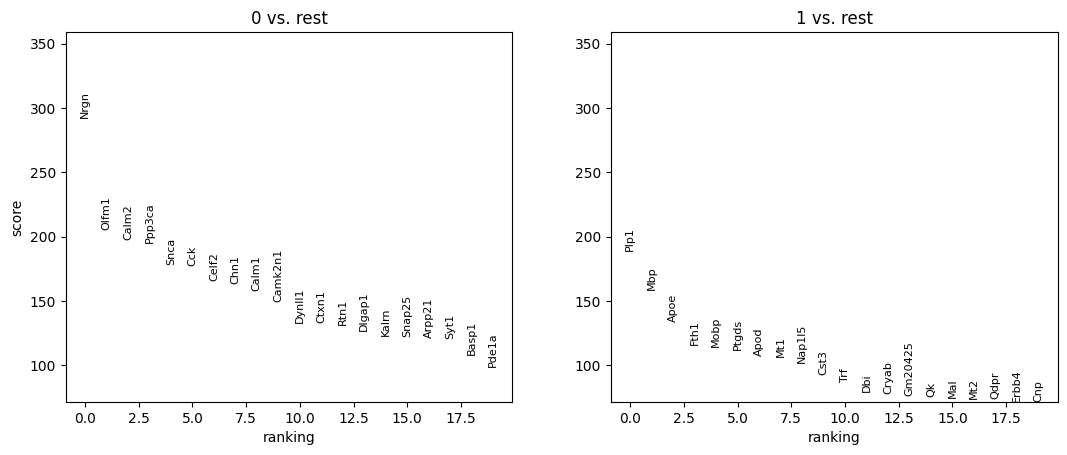

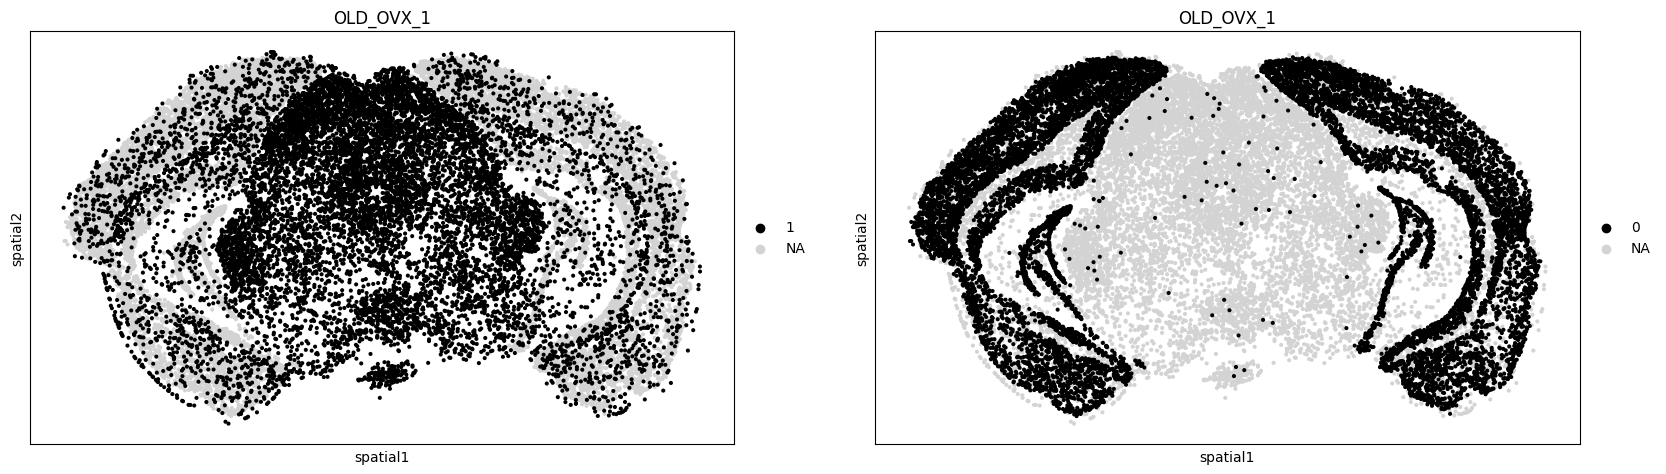

In [9]:
plot_the_outcome(adata_temp)

In [10]:
# sample_name
size_dict = {
    201130: 'midbrainCapsule', 
    213342: 'cortexHippocampus'
}

adata.obs['cell_type'] = 'unknown'
adata = annotate(adata, adata_temp, size_dict)

In [11]:
del adata_temp

In [12]:
adata.write_h5ad('backup.h5ad')

In [45]:
adata = sc.read_h5ad('backup.h5ad')

# Round 2

In [13]:
names = adata.obs['cell_type'].unique()
l_adata_subset = Parallel(n_jobs=len(names))(delayed(cluster)(adata[adata.obs['cell_type'] == k, :].copy()) for k in names)
d_adata_subset = dict(zip(names, l_adata_subset))

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 

preparing SCVI model...
Epoch 1/40:   0%|          | 0/40 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


preparing SCVI model...
Epoch 37/37: 100%|██████████| 37/37 [05:06<00:00,  8.29s/it, v_num=1, train_loss_step=845, train_loss_epoch=622]

`Trainer.fit` stopped: `max_epochs=37` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/d

Epoch 40/40: 100%|██████████| 40/40 [05:11<00:00,  7.79s/it, v_num=1, train_loss_step=612, train_loss_epoch=580]

/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

cortexHippocampus
leiden
0    198145
1     15197
dtype: int64


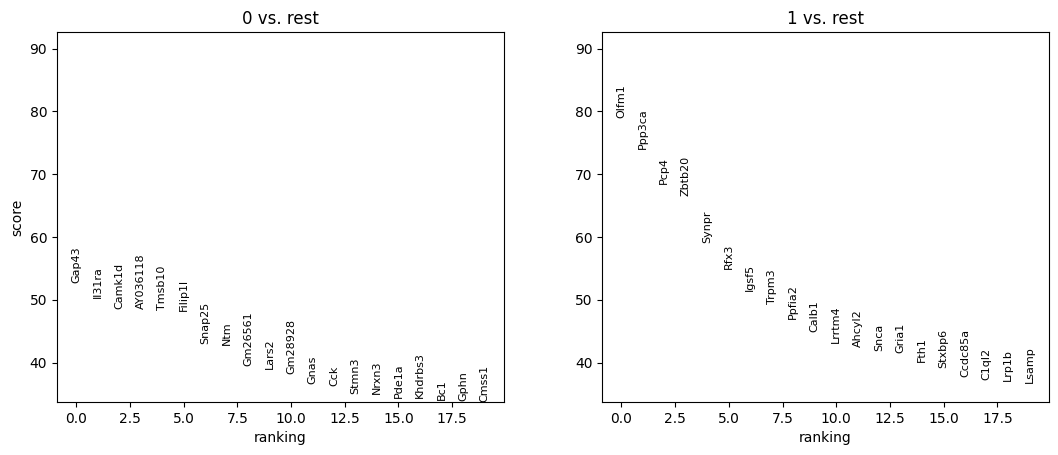

midbrainCapsule
leiden
0    137673
1     33412
2     30045
dtype: int64


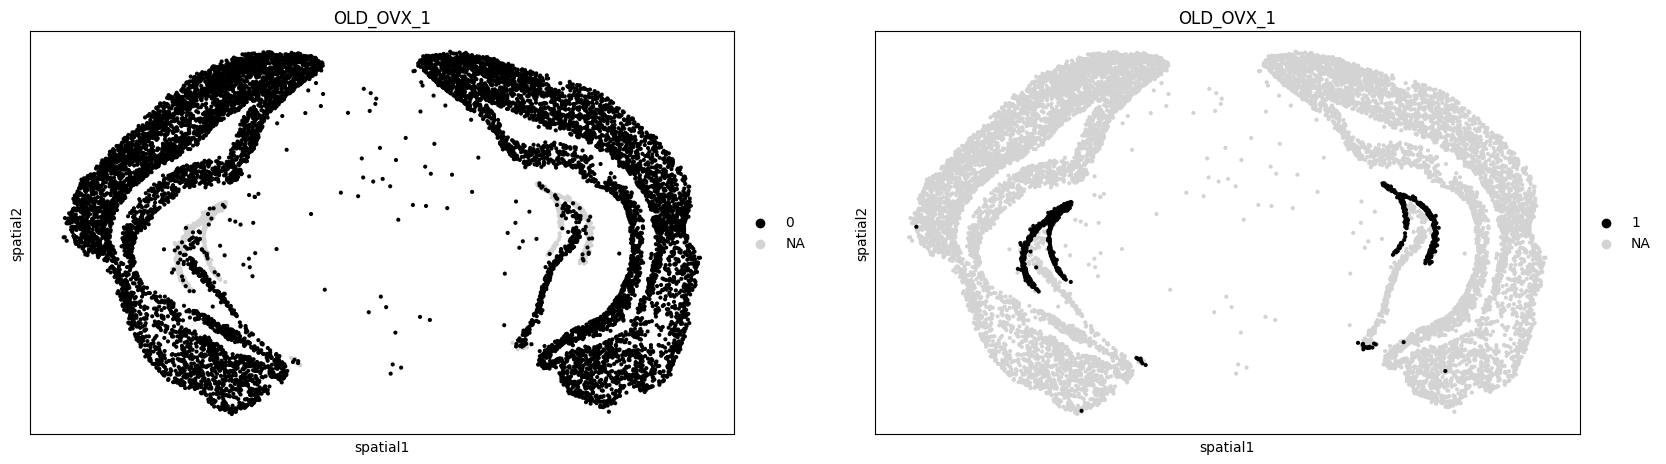

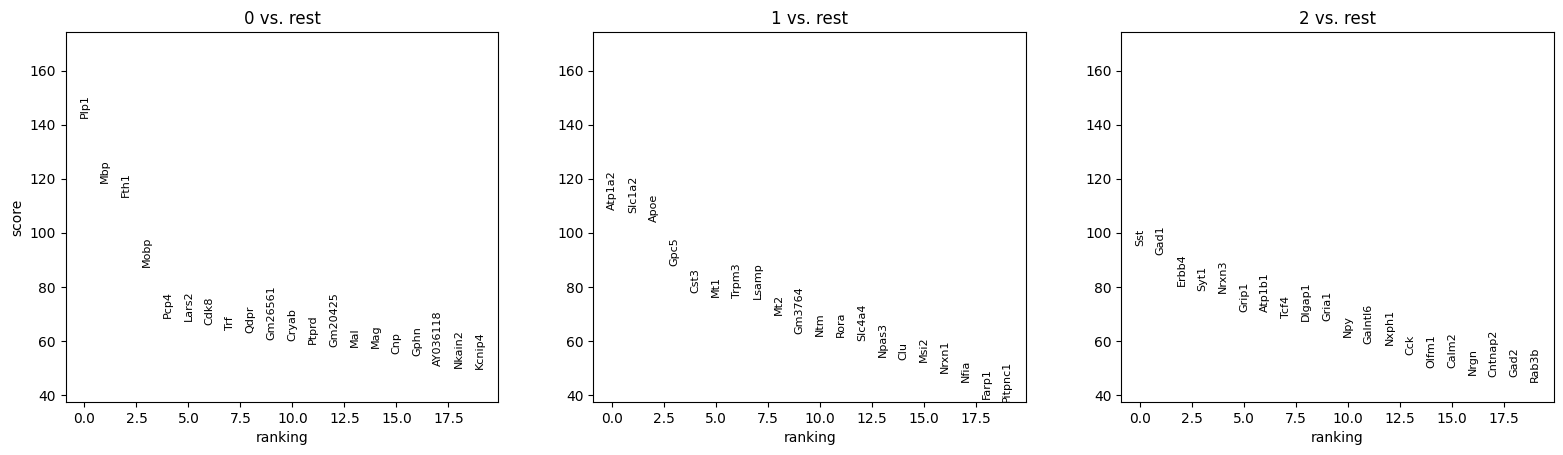

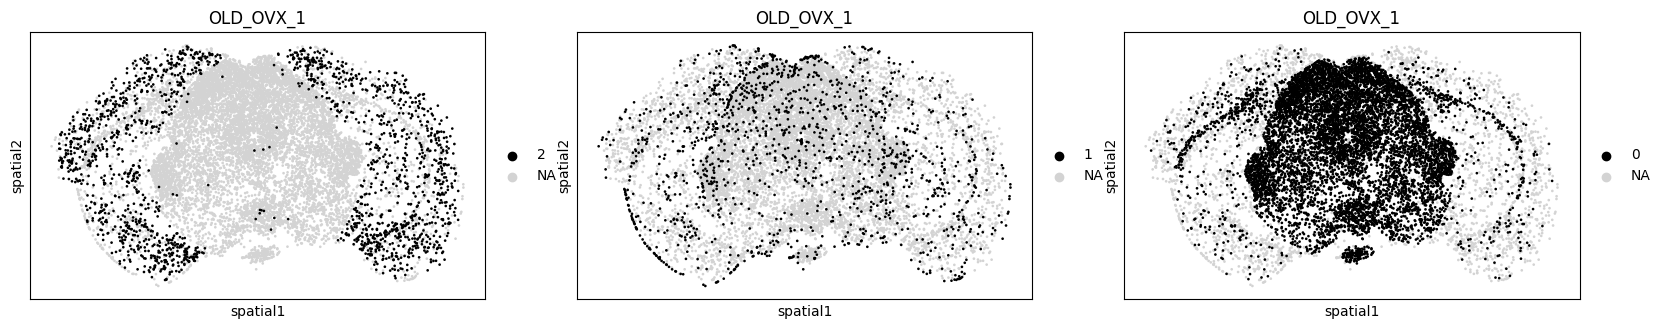

In [14]:
for k,v in d_adata_subset.items():
    print(k)
    plot_the_outcome(v)

In [15]:
def build_size_dict(d_adata_subset):
    size_dict = {}
    for k in d_adata_subset.keys():
        size_dict[k] = {}
        for cl in d_adata_subset[k].obs['leiden'].unique():
            size = d_adata_subset[k].obs.loc[d_adata_subset[k].obs['leiden'] == cl, ].shape[0]
            size_dict[k][size] = 'text'
        size_dict[k] = dict(sorted(size_dict[k].items()))
    return(size_dict)

In [16]:
size_dict = build_size_dict(d_adata_subset)
size_dict

{'cortexHippocampus': {15197: 'text', 198145: 'text'},
 'midbrainCapsule': {30045: 'text', 33412: 'text', 137673: 'text'}}

In [17]:
# sample name
labels = ['dentateGyrus', 'cortexCA3']

for count, k in enumerate(size_dict['cortexHippocampus'].keys()):
    size_dict['cortexHippocampus'][k] = labels[count]

labels = ['corticalInterneurons', 'astrocytes', 'midbrainCapsule']

for count, k in enumerate(size_dict['midbrainCapsule'].keys()):
    size_dict['midbrainCapsule'][k] = labels[count]

size_dict

{'cortexHippocampus': {15197: 'dentateGyrus', 198145: 'cortexCA3'},
 'midbrainCapsule': {30045: 'corticalInterneurons',
  33412: 'astrocytes',
  137673: 'midbrainCapsule'}}

In [18]:
ignore = ['dentateGyrus']

In [19]:
for k,v in d_adata_subset.items():
    print(k)
    adata = annotate(adata, v, size_dict[k])

cortexHippocampus
midbrainCapsule


In [20]:
adata.write_h5ad('backup1.h5ad')

# Round 3

In [21]:
names = adata.obs['cell_type'].unique()
names = [x for x in names if x not in ignore]
l_adata_subset = Parallel(n_jobs=len(names))(delayed(cluster)(adata[adata.obs['cell_type'] == k, :].copy()) for k in names)
d_adata_subset = dict(zip(names, l_adata_subset))


leiden res 0.1...

leiden res 0.1...


/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 

preparing SCVI model...
Epoch 1/266:   0%|          | 0/266 [00:00<?, ?it/s]

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


preparing SCVI model...
Epoch 6/266:   2%|▏         | 5/266 [00:07<06:31,  1.50s/it, v_num=1, train_loss_step=601, train_loss_epoch=561]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 6/239:   2%|▏         | 5/239 [00:08<06:39,  1.71s/it, v_num=1, train_loss_step=427, train_loss_epoch=446]

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


preparing SCVI model...
Epoch 9/239:   3%|▎         | 8/239 [00:14<06:56,  1.80s/it, v_num=1, train_loss_step=468, train_loss_epoch=438]]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


preparing SCVI model...
Epoch 239/239: 100%|██████████| 239/239 [08:44<00:00,  2.20s/it, v_num=1, train_loss_step=429, train_loss_epoch=402]

`Trainer.fit` stopped: `max_epochs=239` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/

Epoch 266/266: 100%|██████████| 266/266 [08:46<00:00,  1.98s/it, v_num=1, train_loss_step=506, train_loss_epoch=512]

/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

Epoch 58/58:  98%|█████████▊| 57/58 [08:37<00:08,  8.99s/it, v_num=1, train_loss_step=716, train_loss_epoch=570]

/home/peter/.local/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


Epoch 58/58: 100%|██████████| 58/58 [08:43<00:00,  9.02s/it, v_num=1, train_loss_step=819, train_loss_epoch=570]

`Trainer.fit` stopped: `max_epochs=58` reached.


Epoch 40/40: 100%|██████████| 40/40 [08:38<00:00, 12.95s/it, v_num=1, train_loss_step=583, train_loss_epoch=617]

`Trainer.fit` stopped: `max_epochs=40` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/d

cortexCA3
leiden
0    142338
1     55390
2       417
dtype: int64


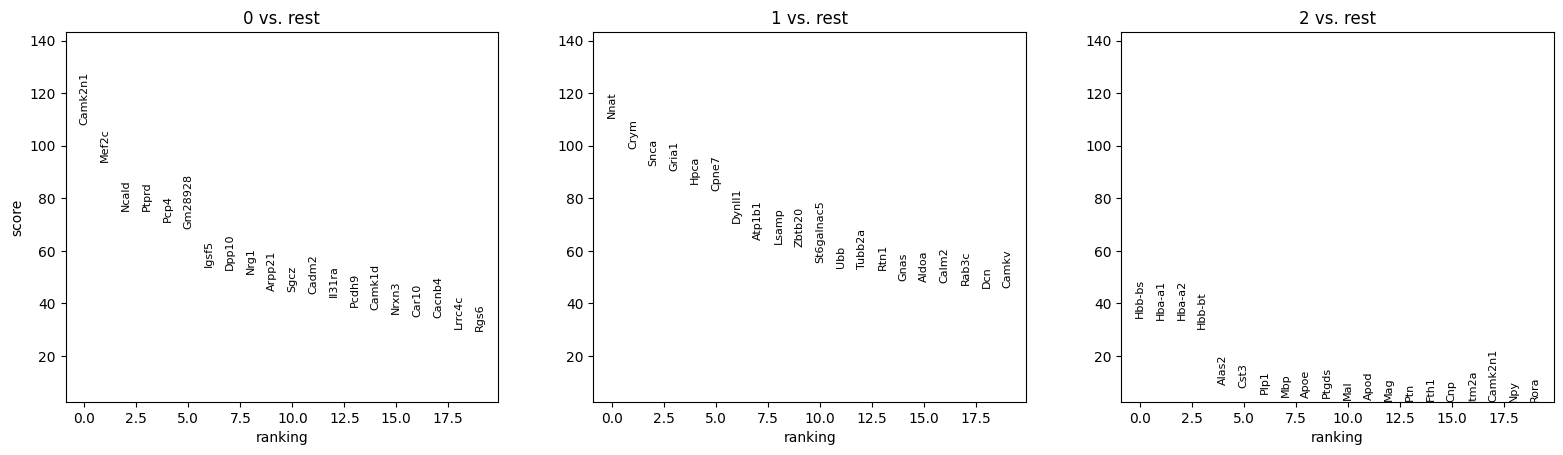

corticalInterneurons
leiden
0    20395
1     9650
dtype: int64


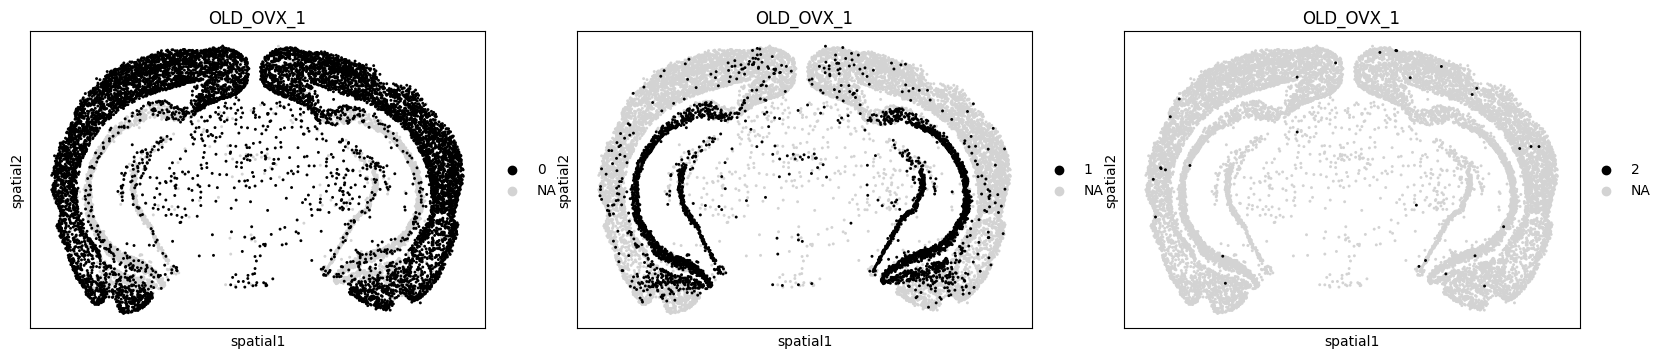

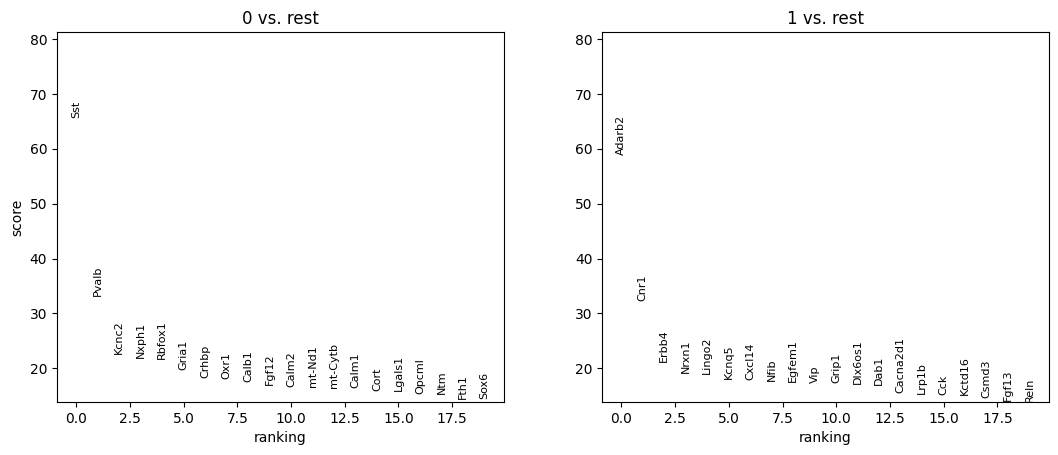

midbrainCapsule
leiden
0    132376
1      5134
2       163
dtype: int64


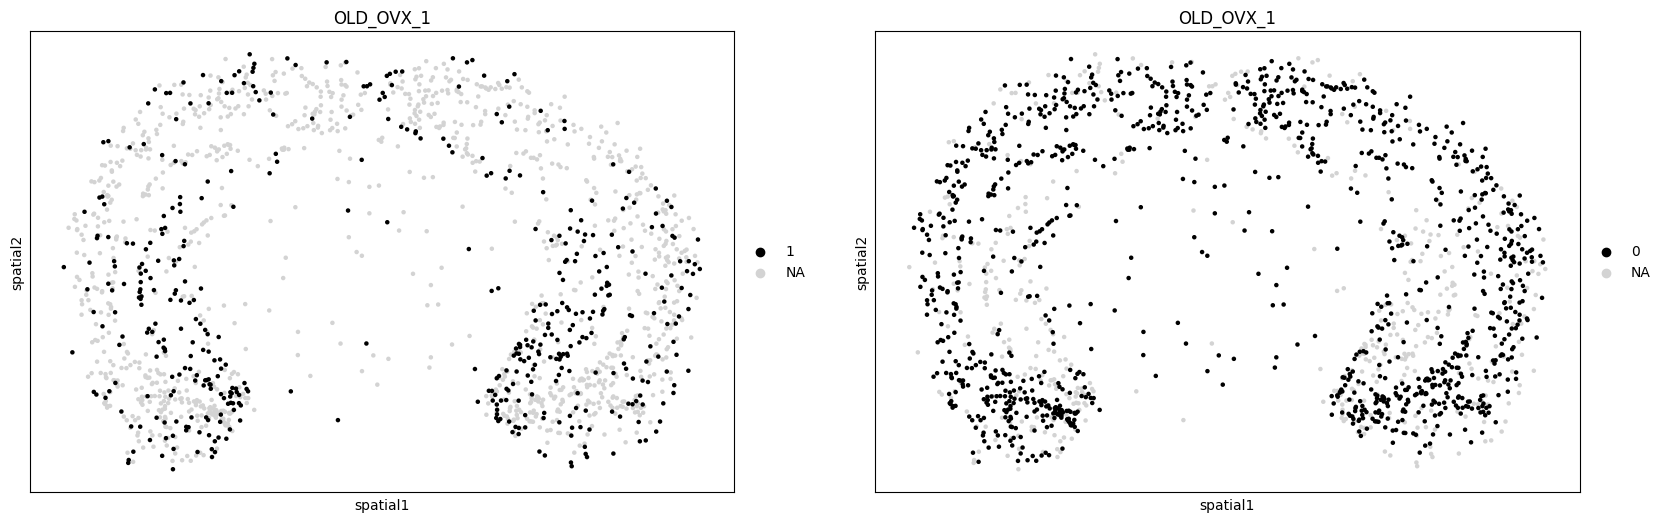

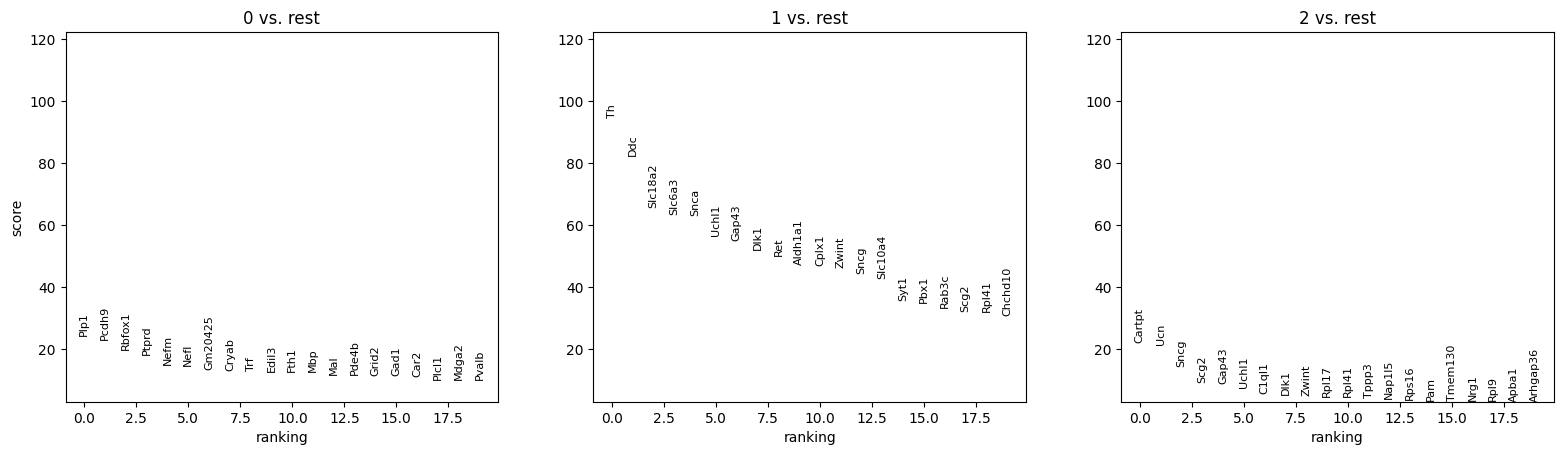

astrocytes
leiden
0    27361
1     6051
dtype: int64


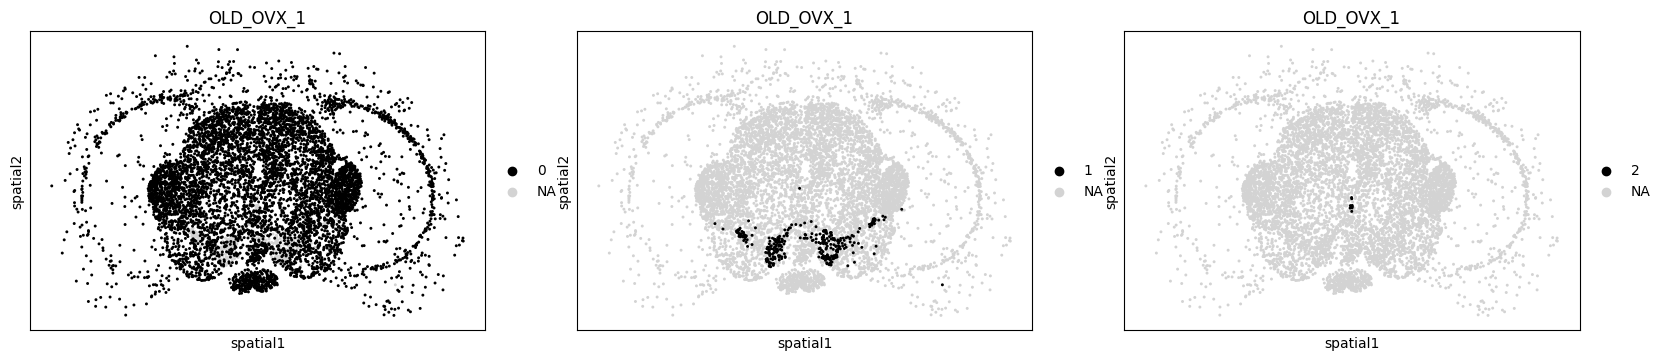

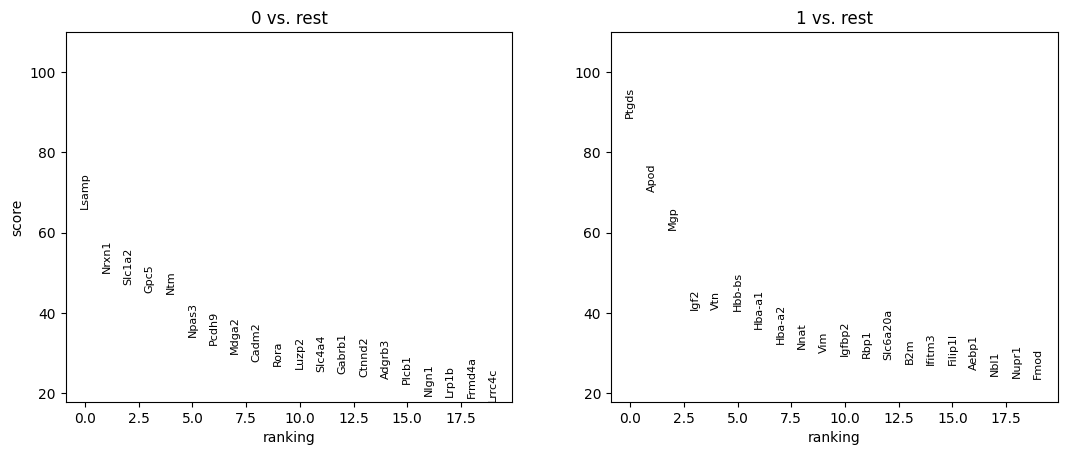

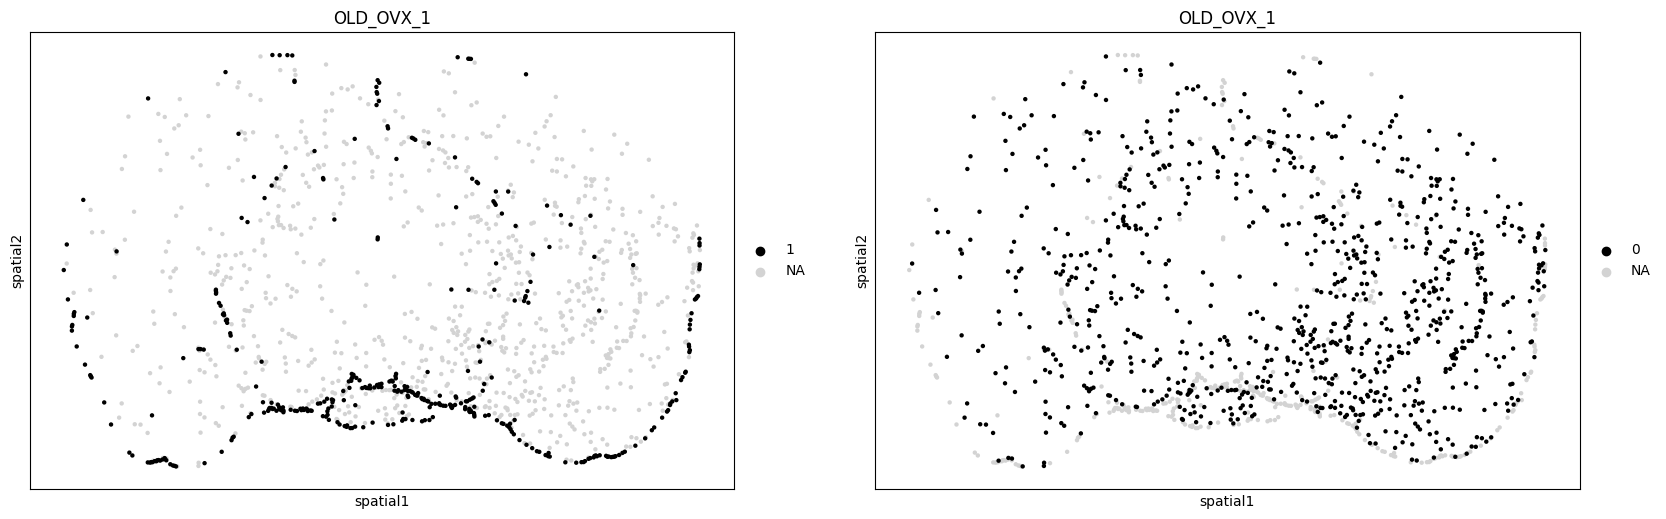

In [24]:
for k,v in d_adata_subset.items():
    print(k)
    plot_the_outcome(v, sample_name='YOUNG_WT_2')

In [28]:
size_dict = build_size_dict(d_adata_subset)
size_dict

{'cortexCA3': {417: 'text', 55390: 'text', 142338: 'text'},
 'corticalInterneurons': {9650: 'text', 20395: 'text'},
 'midbrainCapsule': {163: 'text', 5134: 'text', 132376: 'text'},
 'astrocytes': {6051: 'text', 27361: 'text'}}

In [29]:
labels = ['hbb', 'CA3_CA1', 'cortexCA3']

for count, k in enumerate(size_dict['cortexCA3'].keys()):
    size_dict['cortexCA3'][k] = labels[count]

labels = ['adarb2', 'sst']

for count, k in enumerate(size_dict['corticalInterneurons'].keys()):
    size_dict['corticalInterneurons'][k] = labels[count]

labels = ['Cartpt', 'dopaminergic', 'midbrainCapsule']

for count, k in enumerate(size_dict['midbrainCapsule'].keys()):
    size_dict['midbrainCapsule'][k] = labels[count]

labels = ['meninges', 'astrocytes']

for count, k in enumerate(size_dict['astrocytes'].keys()):
    size_dict['astrocytes'][k] = labels[count]

# labels = ['cortexCA3_CA3', 'cortexCA3_group1', 'cortexCA3_group0']

# for count, k in enumerate(size_dict['cortexCA3'].keys()):
#     size_dict['cortexCA3'][k] = labels[count]

# labels = ['corticalInterneurons_adarb2', 'corticalInterneurons_sst']

# for count, k in enumerate(size_dict['corticalInterneurons'].keys()):
#     size_dict['corticalInterneurons'][k] = labels[count]

# labels = ['midbrainCapsule_dopaminergic', 'midbrainCapsule_thalamic', 'midbrainCapsule_midbrainCapsule']

# for count, k in enumerate(size_dict['midbrainCapsule'].keys()):
#     size_dict['midbrainCapsule'][k] = labels[count]

# labels = ['astrocytes_unknown', 'astrocytes_meninges', 'astrocytes_diffuse']

# for count, k in enumerate(size_dict['astrocytes'].keys()):
#     size_dict['astrocytes'][k] = labels[count]

In [30]:
size_dict

{'cortexCA3': {417: 'hbb', 55390: 'CA3_CA1', 142338: 'cortexCA3'},
 'corticalInterneurons': {9650: 'adarb2', 20395: 'sst'},
 'midbrainCapsule': {163: 'Cartpt',
  5134: 'dopaminergic',
  132376: 'midbrainCapsule'},
 'astrocytes': {6051: 'meninges', 27361: 'astrocytes'}}

In [31]:

[ignore.append(x) for x in ['adarb2', 
                            'meninges',
                            'Cartpt',
                            'dopaminergic',
                            'hbb'
                           ]]

ignore

['dentateGyrus', 'adarb2', 'meninges', 'Cartpt', 'dopaminergic', 'hbb']

In [32]:
adata.write_h5ad('backup2.h5ad')

In [33]:
for k,v in d_adata_subset.items():
    print(k)
    adata = annotate(adata, v, size_dict[k])

cortexCA3
corticalInterneurons
midbrainCapsule
astrocytes


# Round 4

In [34]:
names = adata.obs['cell_type'].unique()
names = [x for x in names if x not in ignore]
l_adata_subset = Parallel(n_jobs=len(names))(delayed(cluster)(adata[adata.obs['cell_type'] == k, :].copy()) for k in names)
d_adata_subset = dict(zip(names, l_adata_subset))

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.setting

preparing SCVI model...
Epoch 2/392:   0%|          | 1/392 [00:01<11:53,  1.83s/it, v_num=1, train_loss_step=583, train_loss_epoch=690]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2/292:   0%|          | 1/292 [00:02<10:25,  2.15s/it, v_num=1, train_loss_step=440, train_loss_epoch=508]

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


preparing SCVI model...
Epoch 5/292:   1%|▏         | 4/292 [00:07<08:17,  1.73s/it, v_num=1, train_loss_step=407, train_loss_epoch=435]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 7/392:   2%|▏         | 6/392 [00:07<07:59,  1.24s/it, v_num=1, train_loss_step=572, train_loss_epoch=571]

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


preparing SCVI model...
Epoch 8/392:   2%|▏         | 7/392 [00:09<07:55,  1.23s/it, v_num=1, train_loss_step=546, train_loss_epoch=567]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch 160/292:  54%|█████▍    | 159/292 [05:45<04:52,  2.20s/it, v_num=1, train_loss_step=455, train_loss_epoch=384]

/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

Epoch 161/292:  55%|█████▍    | 160/292 [05:47<04:37,  2.10s/it, v_num=1, train_loss_step=381, train_loss_epoch=384]

/home/peter/.local/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


Epoch 224/292:  77%|███████▋  | 224/292 [07:44<02:20,  2.07s/it, v_num=1, train_loss_step=372, train_loss_epoch=384]

/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

Epoch 112/144:  77%|███████▋  | 111/144 [07:43<01:58,  3.58s/it, v_num=1, train_loss_step=592, train_loss_epoch=571]

/home/peter/.local/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


Epoch 144/144: 100%|██████████| 144/144 [09:22<00:00,  3.91s/it, v_num=1, train_loss_step=633, train_loss_epoch=571]

`Trainer.fit` stopped: `max_epochs=144` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/

Epoch 60/60: 100%|██████████| 60/60 [09:19<00:00,  9.32s/it, v_num=1, train_loss_step=567, train_loss_epoch=563]

`Trainer.fit` stopped: `max_epochs=60` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distan

Epoch 56/56: 100%|██████████| 56/56 [09:19<00:00,  9.99s/it, v_num=1, train_loss_step=555, train_loss_epoch=585]

`Trainer.fit` stopped: `max_epochs=56` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/d


Monitored metric elbo_validation did not improve in the last 45 records. Best score: 554.760. Signaling Trainer to stop.
leiden res 0.1...
leiden res 0.2...
leiden res 0.30000000000000004...


cortexCA3
leiden
0    117041
1     25297
dtype: int64


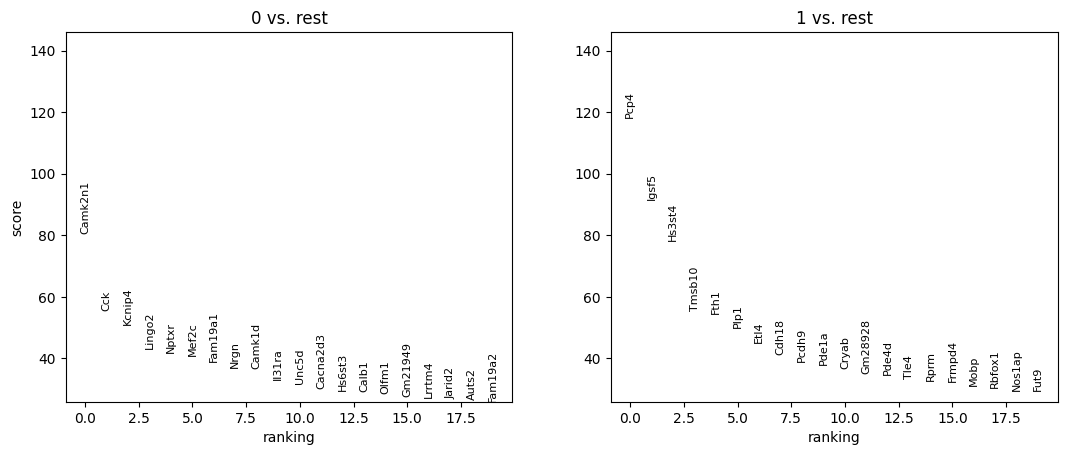

sst
leiden
0    10385
1    10010
dtype: int64


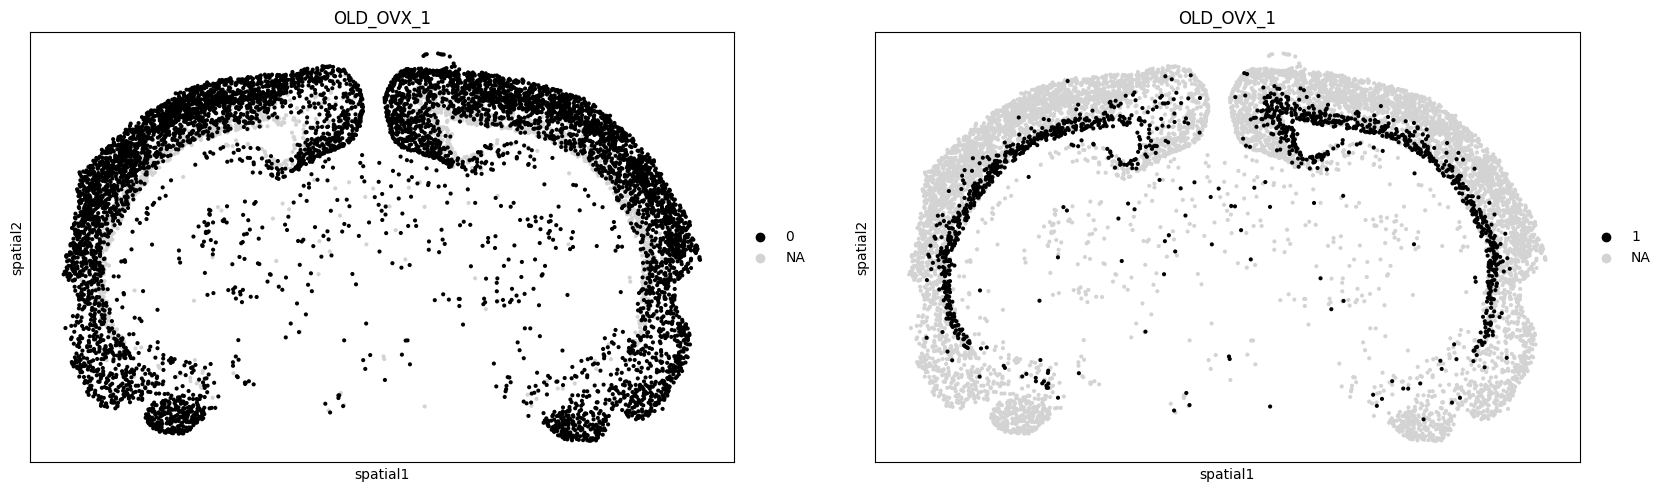

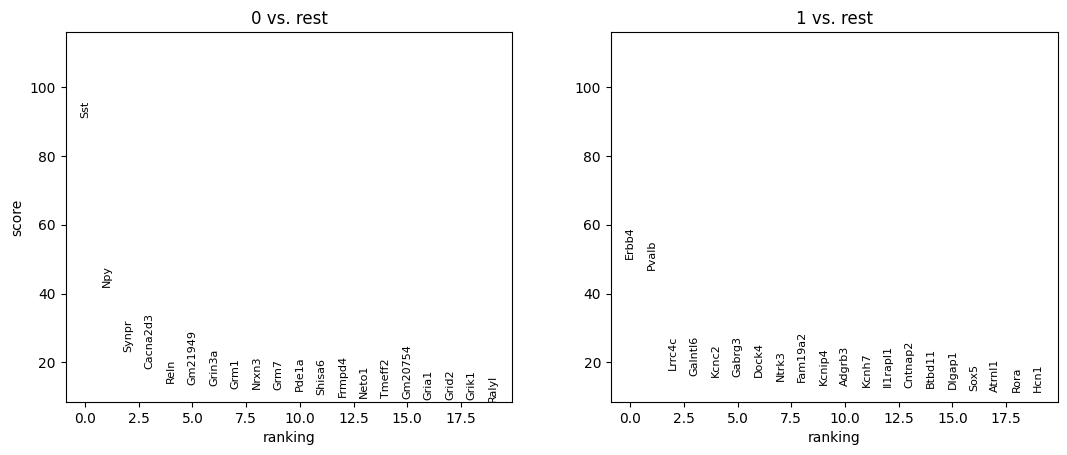

CA3_CA1
leiden
0    16062
1    15681
2    14888
3     8759
dtype: int64


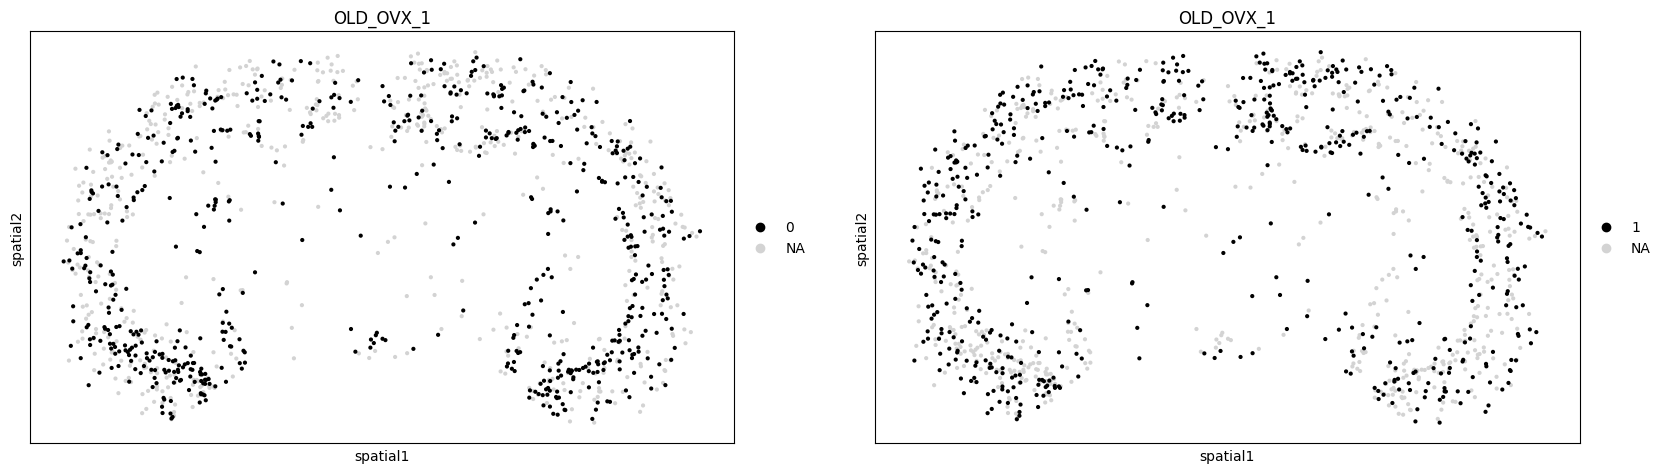

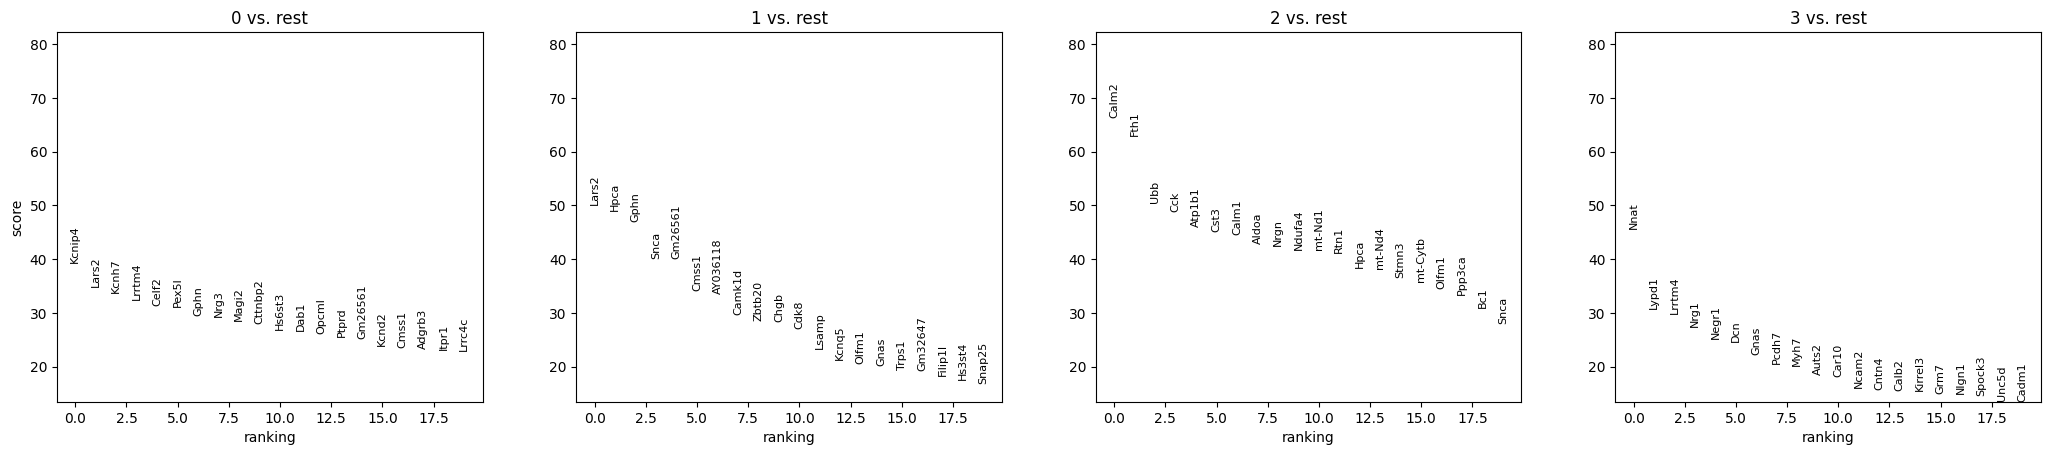

midbrainCapsule
leiden
0    126013
1      6363
dtype: int64


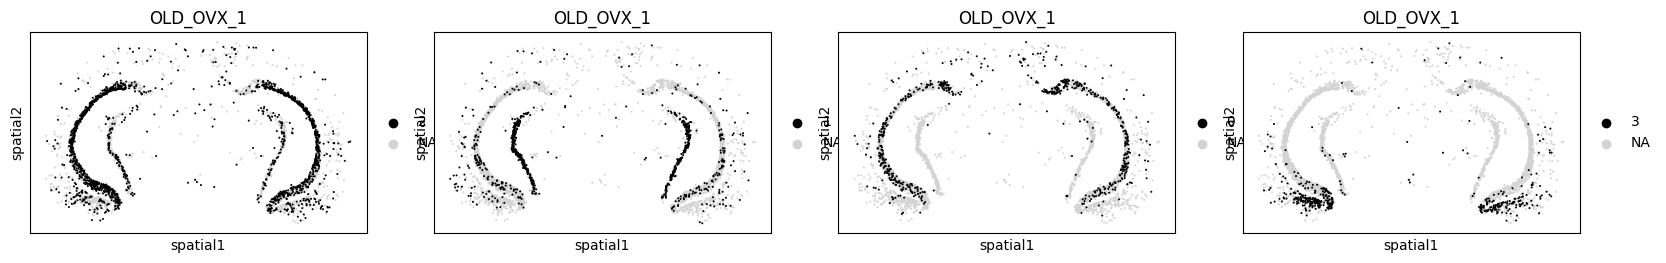

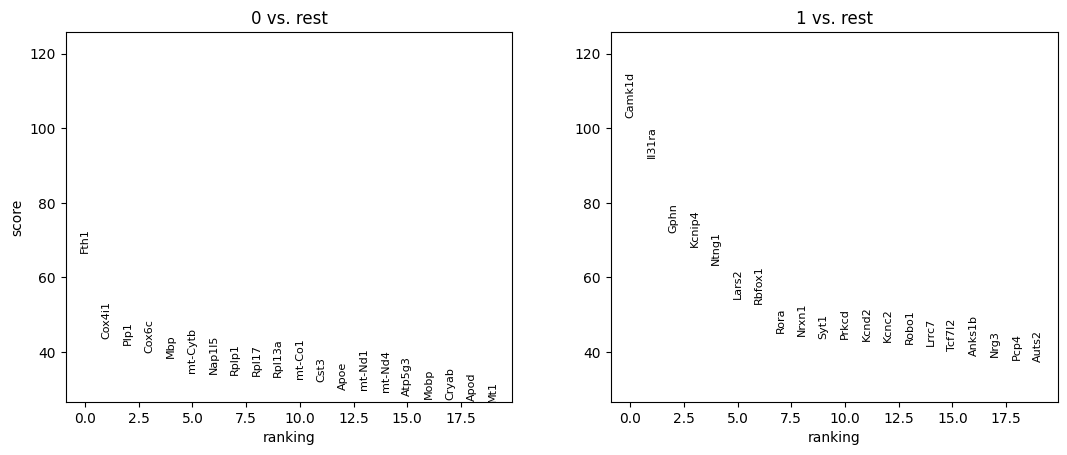

astrocytes
leiden
0    17605
1     9756
dtype: int64


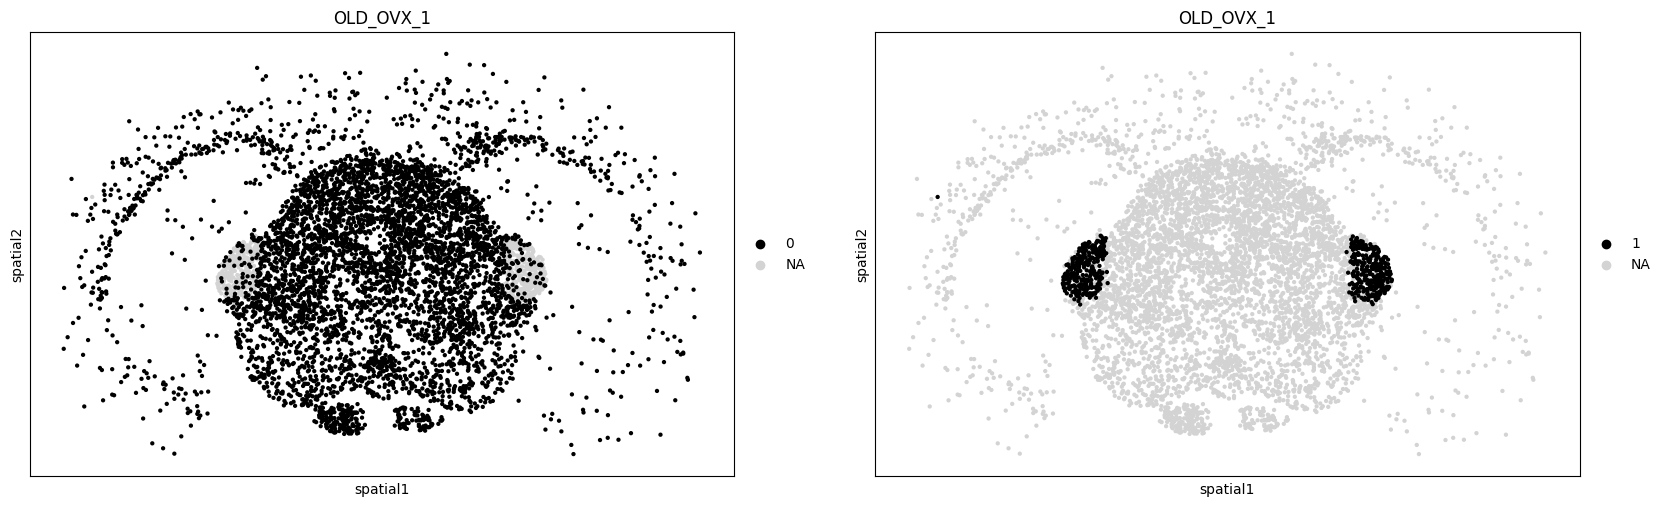

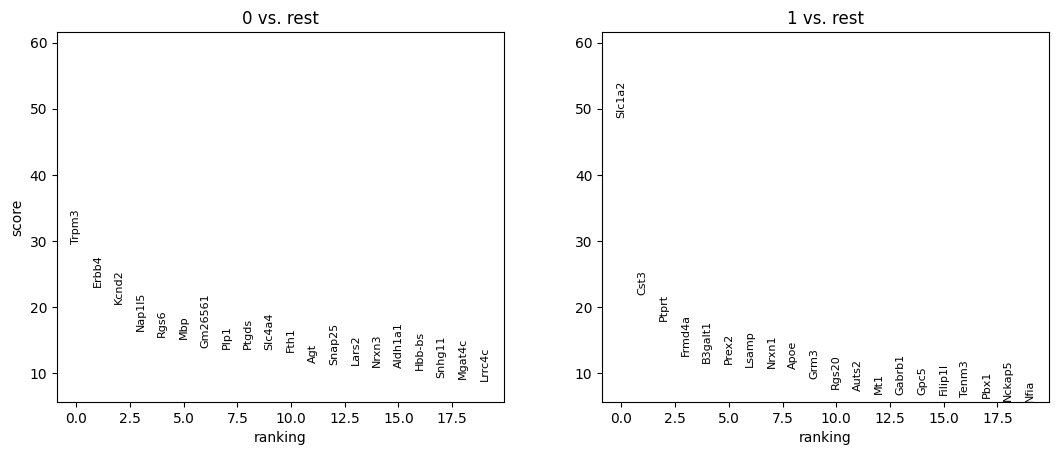

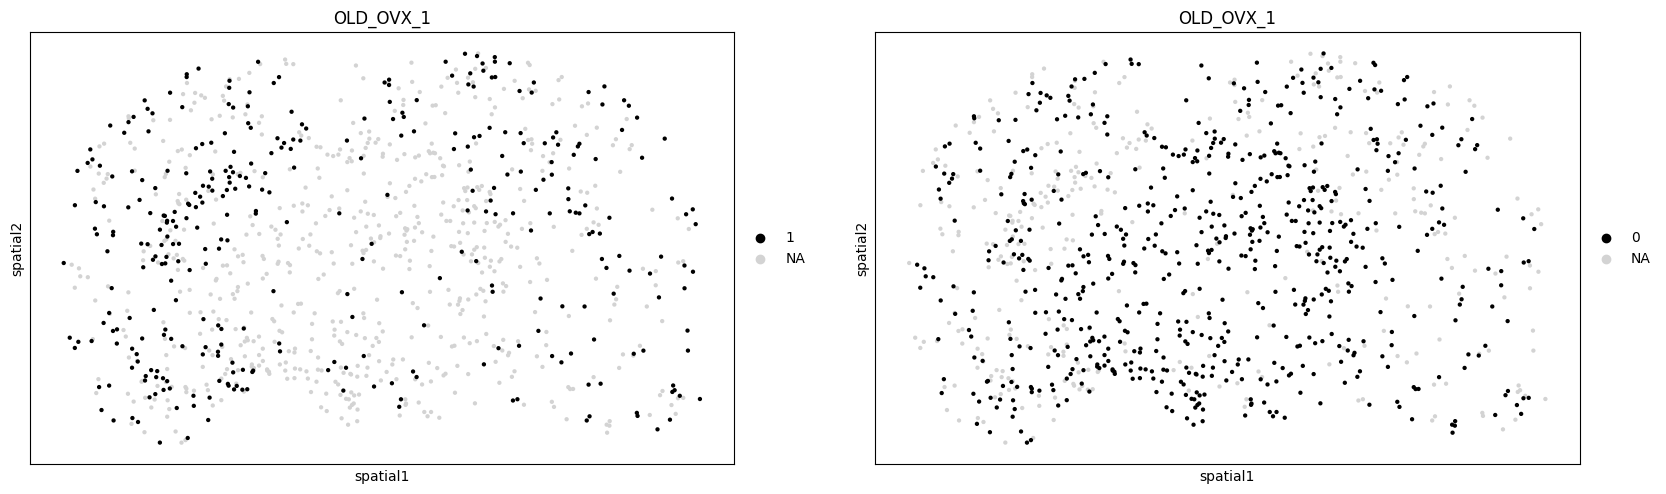


Monitored metric elbo_validation did not improve in the last 45 records. Best score: 417.856. Signaling Trainer to stop.
leiden res 0.1...
leiden res 0.2...
leiden res 0.30000000000000004...


In [38]:
for k,v in d_adata_subset.items():
    print(k)
    plot_the_outcome(v, sample_name='YOUNG_OVX_3')

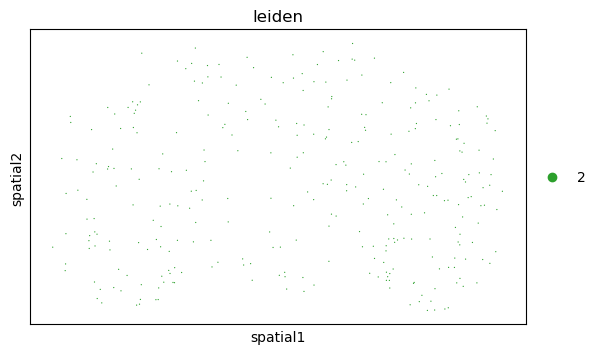

In [87]:
v = d_adata_subset['midbrainCapsule_midbrainCapsule']
v = v[v.obs['sample_name'] == 'OLD_OVX_1', :]
v = v[v.obs['leiden'] == '2', :]
sc.pl.spatial(v, spot_size=50, color = 'leiden')

In [39]:
size_dict = build_size_dict(d_adata_subset)
size_dict

{'cortexCA3': {25297: 'text', 117041: 'text'},
 'sst': {10010: 'text', 10385: 'text'},
 'CA3_CA1': {8759: 'text', 14888: 'text', 15681: 'text', 16062: 'text'},
 'midbrainCapsule': {6363: 'text', 126013: 'text'},
 'astrocytes': {9756: 'text', 17605: 'text'}}


leiden res 0.1...
leiden res 0.2...
leiden res 0.30000000000000004...

leiden res 0.1...

leiden res 0.1...
leiden res 0.2...


In [40]:
labels = ['L6', 'cortex']

for count, k in enumerate(size_dict['cortexCA3'].keys()):
    size_dict['cortexCA3'][k] = labels[count]

labels = ['pvalb', 'sst']

for count, k in enumerate(size_dict['sst'].keys()):
    size_dict['sst'][k] = labels[count]

labels = ['amygdalaVentralSubiculum', 
          'CA3', 
          'CA1_CA3',
         'CA3_CA1']

for count, k in enumerate(size_dict['CA3_CA1'].keys()):
    size_dict['CA3_CA1'][k] = labels[count]

labels = ['thalamus', 'midbrainCapsule']

for count, k in enumerate(size_dict['midbrainCapsule'].keys()):
    size_dict['midbrainCapsule'][k] = labels[count]

labels = ['astrocytes_group1', 'astrocytes_group0']

for count, k in enumerate(size_dict['astrocytes'].keys()):
    size_dict['astrocytes'][k] = labels[count]

# labels = ['cortexCA3_group0_group1', 'cortexCA3_group0_group0']

# for count, k in enumerate(size_dict['cortexCA3_group0'].keys()):
#     size_dict['cortexCA3_group0'][k] = labels[count]

# labels = ['cortexCA3_group1_hbb', 'cortexCA3_group1_group1', 'cortexCA3_group1_group0']

# for count, k in enumerate(size_dict['cortexCA3_group1'].keys()):
#     size_dict['cortexCA3_group1'][k] = labels[count]

# labels = ['midbrainCapsule_midbrainCapsule_cartpt', 'midbrainCapsule_midbrainCapsule_optic', 'midbrainCapsule_midbrainCapsule_microglia', 
#           'midbrainCapsule_midbrainCapsule_OPC', 'midbrainCapsule_midbrainCapsule_glial', 'midbrainCapsule_midbrainCapsule_neuronal']

# for count, k in enumerate(size_dict['midbrainCapsule_midbrainCapsule'].keys()):
#     size_dict['midbrainCapsule_midbrainCapsule'][k] = labels[count]

# labels = ['astrocytes_diffuse_type1', 'astrocytes_diffuse_type0']

# for count, k in enumerate(size_dict['astrocytes_diffuse'].keys()):
#     size_dict['astrocytes_diffuse'][k] = labels[count]

# labels = ['midbrainCapsule_dopaminergic_group1', 'midbrainCapsule_dopaminergic_group0']

# for count, k in enumerate(size_dict['midbrainCapsule_dopaminergic'].keys()):
#     size_dict['midbrainCapsule_dopaminergic'][k] = labels[count]

In [41]:
size_dict

{'cortexCA3': {25297: 'L6', 117041: 'cortex'},
 'sst': {10010: 'pvalb', 10385: 'sst'},
 'CA3_CA1': {8759: 'amygdalaVentralSubiculum',
  14888: 'CA3',
  15681: 'CA1_CA3',
  16062: 'CA3_CA1'},
 'midbrainCapsule': {6363: 'thalamus', 126013: 'midbrainCapsule'},
 'astrocytes': {9756: 'astrocytes_group1', 17605: 'astrocytes_group0'}}

In [42]:
ignore.append('sst')
ignore.append('pvalb')
ignore.append('astrocytes_group1')
ignore.append('astrocytes_group0')

ignore

['dentateGyrus',
 'adarb2',
 'meninges',
 'Cartpt',
 'dopaminergic',
 'hbb',
 'sst',
 'pvalb',
 'astrocytes_group1',
 'astrocytes_group0']

In [43]:
adata.write_h5ad('backup3.h5ad')

In [44]:
adata = sc.read_h5ad('backup3.h5ad')

In [ ]:
# labels = ['cortexCA3_outer_retrosplenial', 'cortexCA3_outer_deep', 'cortexCA3_outer_superficial']
# ignore.append( 'cortexCA3_outer_retrosplenial')

# for count, k in enumerate(size_dict['cortexCA3_outer'].keys()):
#     size_dict['cortexCA3_outer'][k] = labels[count]

# labels = ['cortexCA3_inner_DorsalSubic', 'cortexCA3_inner_CA3', 'cortexCA3_inner_CA1VentralSubic']

# for count, k in enumerate(size_dict['cortexCA3_inner'].keys()):
#     size_dict['cortexCA3_inner'][k] = labels[count]

# labels = ['midbrainCapsuleGlia_midbrainCapsuleGlia_Cartpt', 'midbrainCapsuleGlia_midbrainCapsuleGlia_midbrainCapsuleGlia']

# for count, k in enumerate(size_dict['midbrainCapsuleGlia_midbrainCapsuleGlia'].keys()):
#     size_dict['midbrainCapsuleGlia_midbrainCapsuleGlia'][k] = labels[count]

# labels = ['diffuseAstrocytes_diffuse_midbrain', 'diffuseAstrocytes_diffuse_cortical']

# for count, k in enumerate(size_dict['diffuseAstrocytes_diffuse'].keys()):
#     size_dict['diffuseAstrocytes_diffuse'][k] = labels[count]

# labels = ['diffuseAstrocytes_meninges_group1', 'diffuseAstrocytes_meninges_group2']

# for count, k in enumerate(size_dict['diffuseAstrocytes_meninges'].keys()):
#     size_dict['diffuseAstrocytes_meninges'][k] = labels[count]

# labels = ['midbrainCapsuleGlia_thalamus_nonMGN', 'midbrainCapsuleGlia_thalamus_MGN']

# for count, k in enumerate(size_dict['midbrainCapsuleGlia_thalamus'].keys()):
#     size_dict['midbrainCapsuleGlia_thalamus'][k] = labels[count]

In [45]:
for k,v in d_adata_subset.items():
    print(k)
    adata = annotate(adata, v, size_dict[k])

cortexCA3
sst
CA3_CA1
midbrainCapsule
astrocytes


In [46]:
adata.write_h5ad('backup4.h5ad')

In [71]:
adata = sc.read_h5ad('backup4.h5ad')

In [72]:
adata.obs.groupby('cell_type').size()

cell_type
CA1_CA3                      15681
CA3                          14888
CA3_CA1                      16062
Cartpt                         163
L6                           25297
adarb2                        9650
amygdalaVentralSubiculum      8759
astrocytes_group0            17605
astrocytes_group1             9756
cortex                      117041
dentateGyrus                 15197
dopaminergic                  5134
hbb                            417
meninges                      6051
midbrainCapsule             126013
pvalb                        10010
sst                          10385
thalamus                      6363
dtype: int64

# Round 5

In [73]:
ignore.append('CA3')
ignore.append('thalamus')
ignore.append('CA1_CA3')
ignore.append('CA3_CA1')
ignore.append('amygdalaVentralSubiculum')
ignore.append('cortex')


In [74]:
ignore

['dentateGyrus',
 'adarb2',
 'meninges',
 'Cartpt',
 'dopaminergic',
 'hbb',
 'sst',
 'pvalb',
 'astrocytes_group1',
 'astrocytes_group0',
 'CA3',
 'thalamus',
 'CA1_CA3',
 'CA3_CA1',
 'amygdalaVentralSubiculum',
 'cortex',
 'CA3',
 'thalamus',
 'CA1_CA3',
 'CA3_CA1',
 'amygdalaVentralSubiculum',
 'cortex']

In [49]:
# ignore = ['dentateGyrus',
#  'cortexCA3_CA3',
#  'corticalInterneurons_adarb2',
#  'corticalInterneurons_sst',
#  'midbrainCapsule_thalamic',
#  'astrocytes_unknown',
#  'astrocytes_meninges',
#  'cortexCA3_group1_hbb',
#  'midbrainCapsule_midbrainCapsule_cartpt',
#  'midbrainCapsule_midbrainCapsule_optic',
#  'midbrainCapsule_midbrainCapsule_microglia',
#  'midbrainCapsule_midbrainCapsule_OPC',
#  'astrocytes_diffuse_type1',
#  'astrocytes_diffuse_type0', 
#           'cortexCA3_group0_group0', 
#           'cortexCA3_group0_group1', 
#           'cortexCA3_group1_group0', 
#           'cortexCA3_group1_group1', 
#           'midbrainCapsule_dopaminergic_group0', 
#           'midbrainCapsule_dopaminergic_group1'
#          ]

# ignore.remove('corticalInterneurons_sst')
# ignore.remove('corticalInterneurons_adarb2')

# ignore

In [75]:
names = adata.obs['cell_type'].unique()
names = [x for x in names if x not in ignore]
l_adata_subset = Parallel(n_jobs=len(names))(delayed(cluster)(adata[adata.obs['cell_type'] == k, :].copy()) for k in names)
d_adata_subset = dict(zip(names, l_adata_subset))

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 

preparing SCVI model...
Epoch 4/316:   1%|          | 3/316 [00:03<05:20,  1.02s/it, v_num=1, train_loss_step=573, train_loss_epoch=582]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Epoch 235/316:  74%|███████▍  | 235/316 [03:49<01:19,  1.02it/s, v_num=1, train_loss_step=525, train_loss_epoch=519]

/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

Epoch 48/63:  75%|███████▍  | 47/63 [03:46<01:15,  4.69s/it, v_num=1, train_loss_step=850, train_loss_epoch=554]

/home/peter/.local/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


Epoch 63/63: 100%|██████████| 63/63 [04:45<00:00,  4.54s/it, v_num=1, train_loss_step=604, train_loss_epoch=553]

`Trainer.fit` stopped: `max_epochs=63` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/d

L6
leiden
0    13310
1    11987
dtype: int64


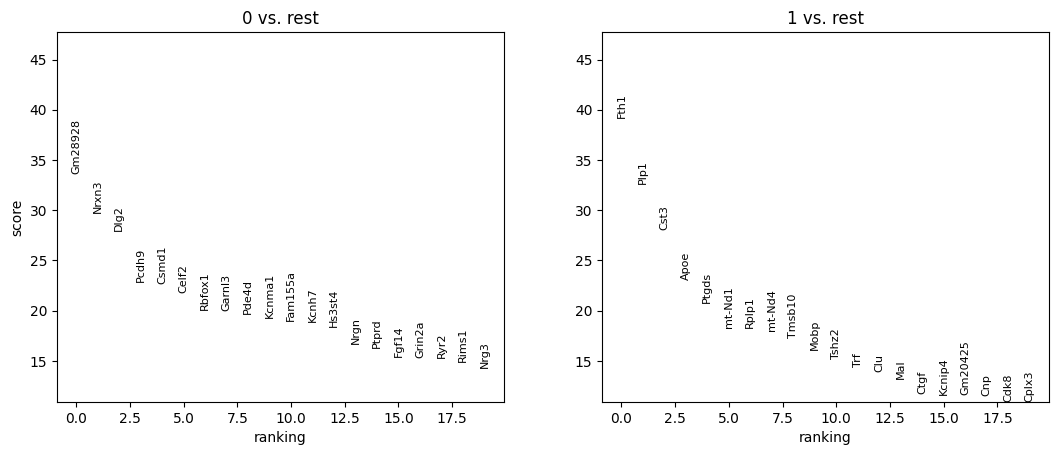

midbrainCapsule
leiden
0    83998
1    37360
2     3161
3     1494
dtype: int64


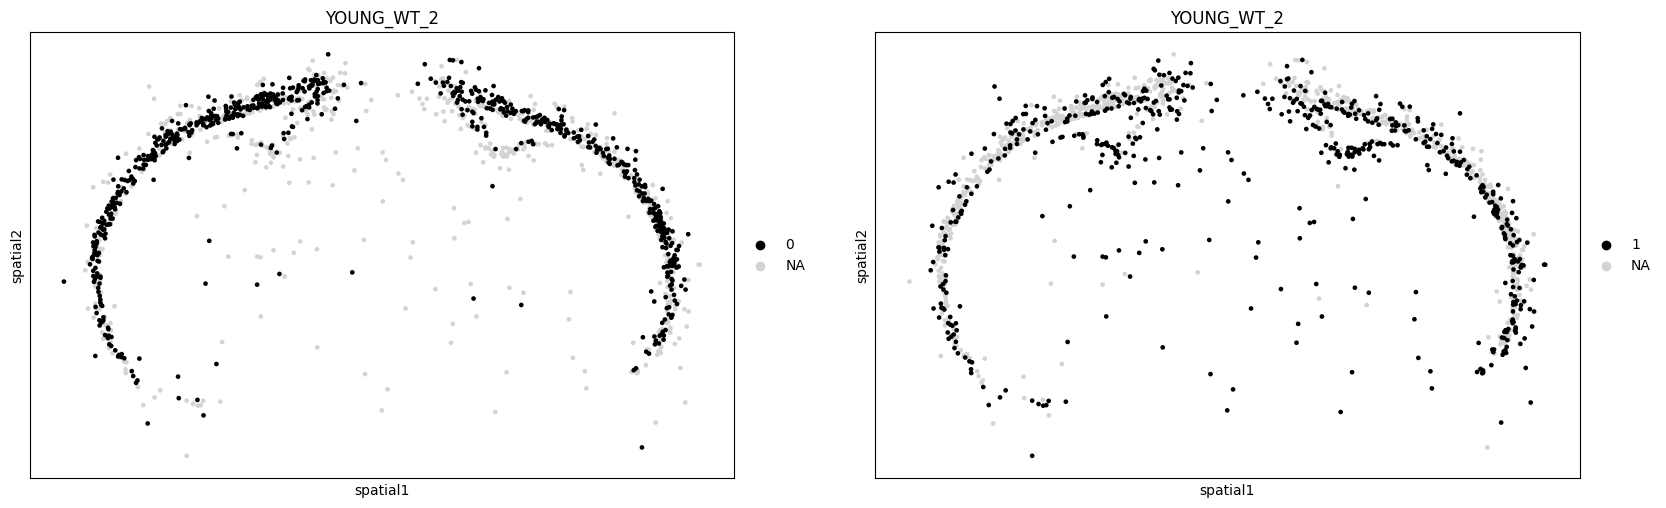

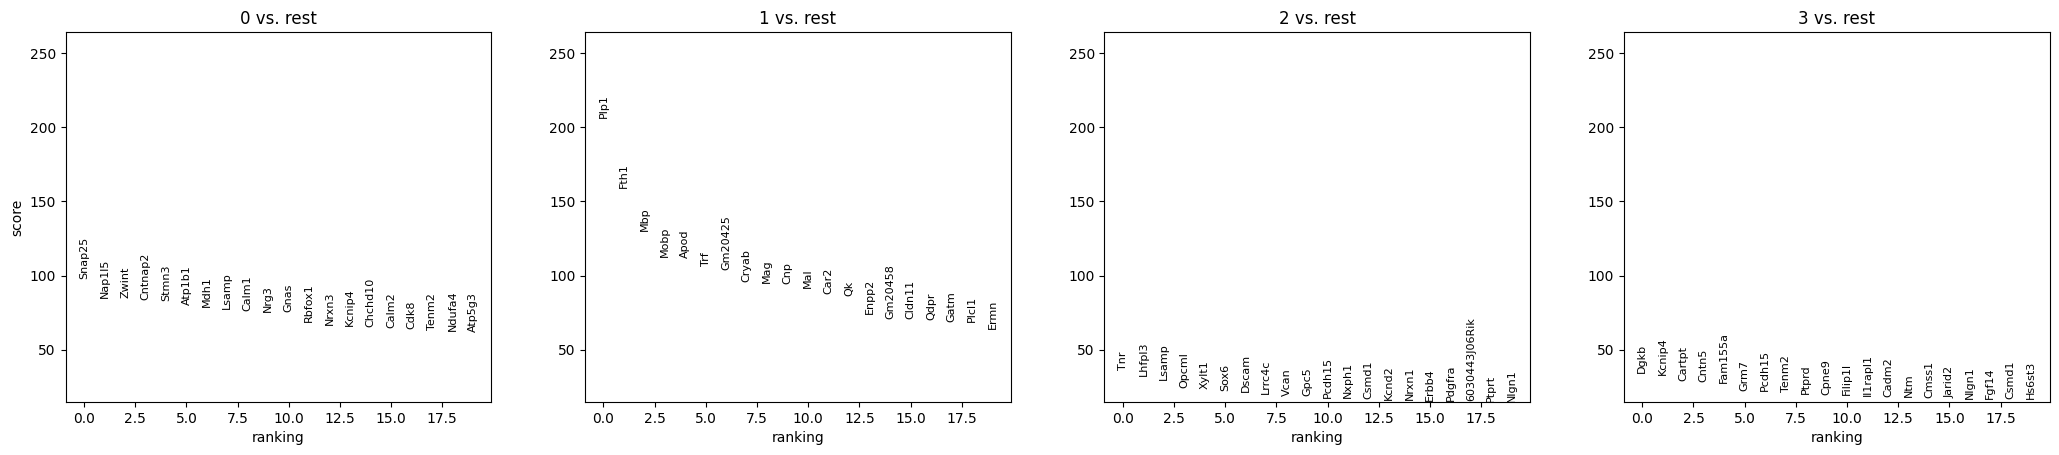

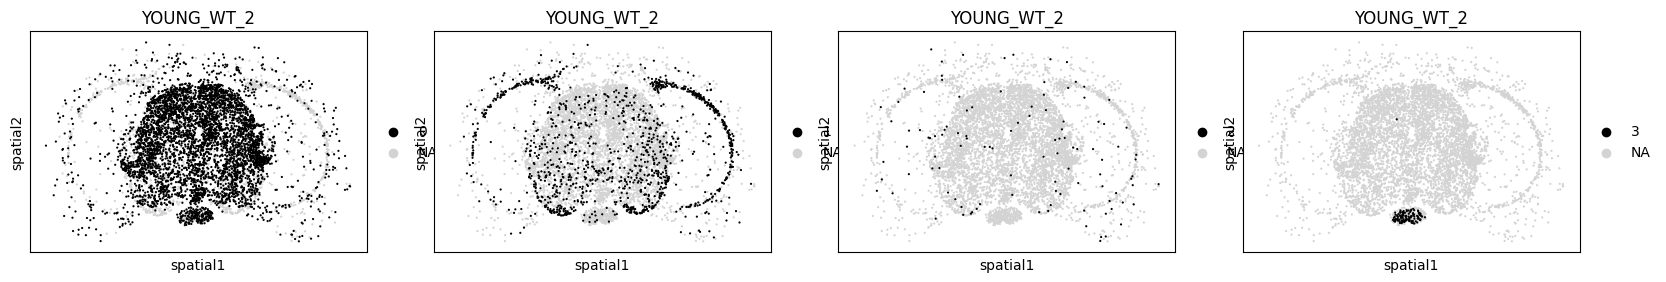

In [76]:
for k,v in d_adata_subset.items():
    print(k)
    plot_the_outcome(v, sample_name='YOUNG_WT_2')

In [77]:
size_dict = build_size_dict(d_adata_subset)
size_dict

{'L6': {11987: 'text', 13310: 'text'},
 'midbrainCapsule': {1494: 'text', 3161: 'text', 37360: 'text', 83998: 'text'}}

In [78]:
labels = ['L6_plp1', 'L6']

for count, k in enumerate(size_dict['L6'].keys()):
    size_dict['L6'][k] = labels[count]

labels = ['optic', 'unknown', 'oligo', 'midbrainCapsule']

for count, k in enumerate(size_dict['midbrainCapsule'].keys()):
    size_dict['midbrainCapsule'][k] = labels[count]

In [79]:
for k,v in d_adata_subset.items():
    if k in size_dict.keys():
        print(k)
        adata = annotate(adata, v, size_dict[k])

L6
midbrainCapsule


In [80]:
adata.obs.groupby('cell_type').size()

cell_type
CA1_CA3                      15681
CA3                          14888
CA3_CA1                      16062
Cartpt                         163
L6                           13310
L6_plp1                      11987
adarb2                        9650
amygdalaVentralSubiculum      8759
astrocytes_group0            17605
astrocytes_group1             9756
cortex                      117041
dentateGyrus                 15197
dopaminergic                  5134
hbb                            417
meninges                      6051
midbrainCapsule              83998
oligo                        37360
optic                         1494
pvalb                        10010
sst                          10385
thalamus                      6363
unknown                       3161
dtype: int64

In [81]:
adata.write_h5ad('backup6.h5ad')


Monitored metric elbo_validation did not improve in the last 45 records. Best score: 554.051. Signaling Trainer to stop.
leiden res 0.1...
leiden res 0.2...
leiden res 0.30000000000000004...


In [83]:
ignore.append('L6')
ignore.append('L6_plp1')
ignore.append('unknown')
ignore.append('optic')


In [86]:
ignore = list(set(ignore))
ignore

['astrocytes_group0',
 'Cartpt',
 'sst',
 'pvalb',
 'L6',
 'astrocytes_group1',
 'adarb2',
 'amygdalaVentralSubiculum',
 'optic',
 'CA1_CA3',
 'CA3',
 'CA3_CA1',
 'unknown',
 'dentateGyrus',
 'cortex',
 'dopaminergic',
 'L6_plp1',
 'hbb',
 'meninges',
 'thalamus']

# Round 6

In [87]:
names = adata.obs['cell_type'].unique()
names = [x for x in names if x not in ignore]
l_adata_subset = Parallel(n_jobs=len(names))(delayed(cluster)(adata[adata.obs['cell_type'] == k, :].copy()) for k in names)
d_adata_subset = dict(zip(names, l_adata_subset))

/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/peter/mambaforge/envs/rapids_singlecell/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_key


leiden res 0.1...
leiden res 0.2...
preparing SCVI model...
Epoch 1/95:   0%|          | 0/95 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


preparing SCVI model...
Epoch 95/95: 100%|██████████| 95/95 [05:10<00:00,  3.27s/it, v_num=1, train_loss_step=566, train_loss_epoch=566]396]

`Trainer.fit` stopped: `max_epochs=95` reached.


Epoch 214/214: 100%|██████████| 214/214 [05:11<00:00,  1.46s/it, v_num=1, train_loss_step=387, train_loss_epoch=395]

`Trainer.fit` stopped: `max_epochs=214` reached.
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/peter/.local/lib/python3.10/site-packages/umap/

midbrainCapsule
leiden
0    83374
1      624
dtype: int64


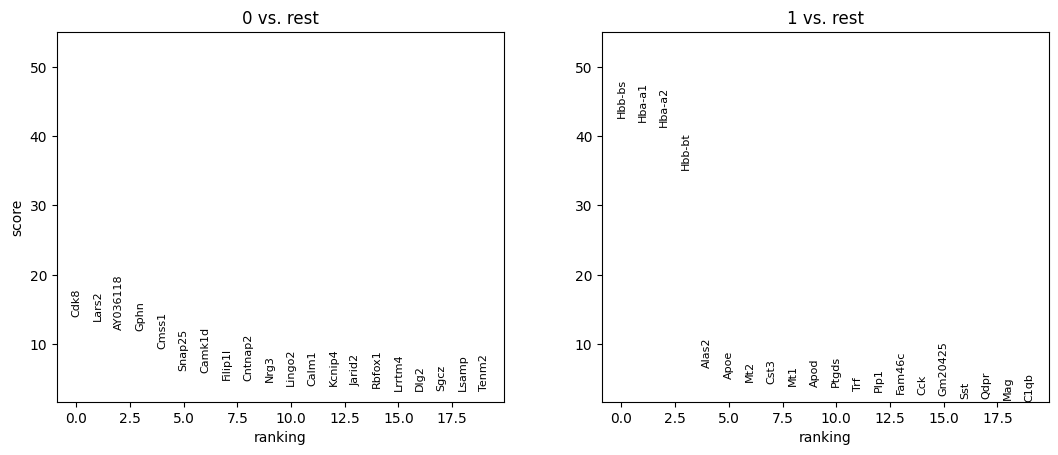

oligo
leiden
0    34040
1     3320
dtype: int64


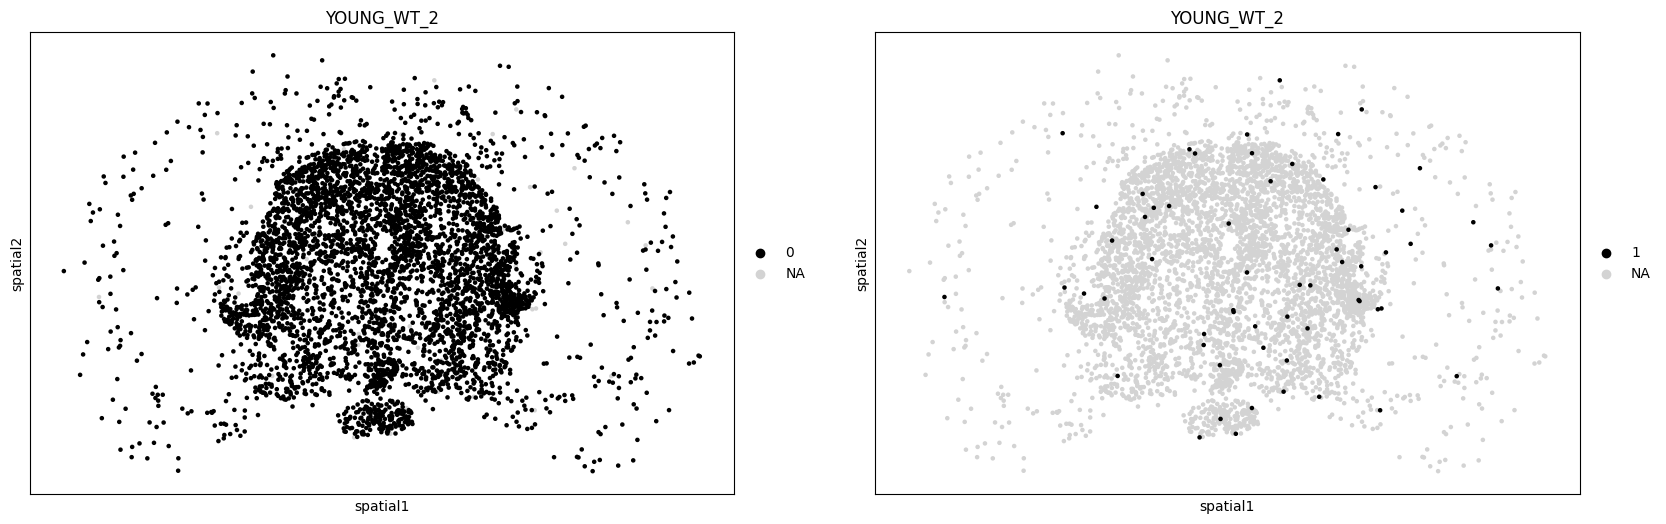

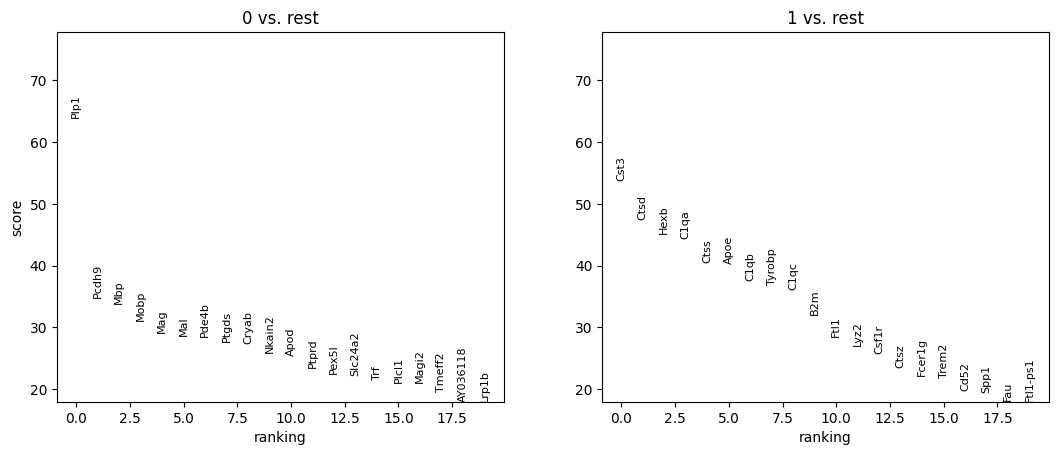

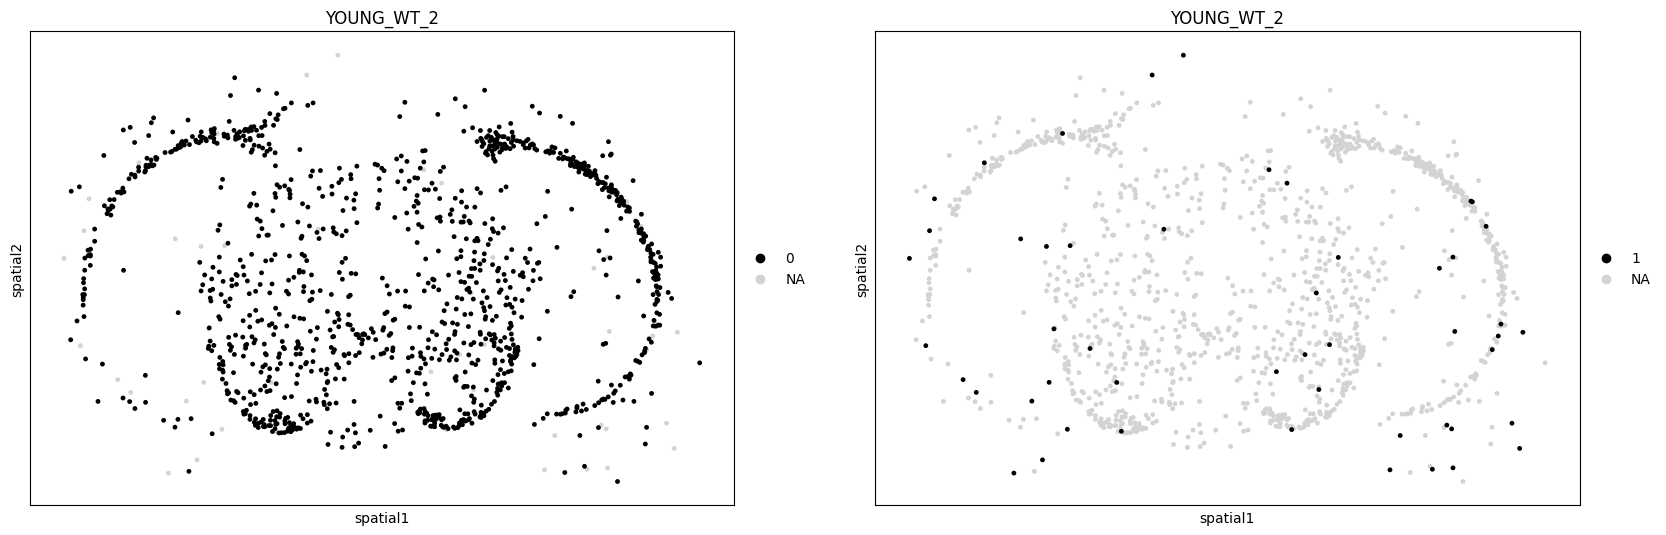

In [88]:
for k,v in d_adata_subset.items():
    print(k)
    plot_the_outcome(v, sample_name='YOUNG_WT_2')

In [89]:
size_dict = build_size_dict(d_adata_subset)
size_dict

{'midbrainCapsule': {624: 'text', 83374: 'text'},
 'oligo': {3320: 'text', 34040: 'text'}}

In [90]:
labels = ['hbb_2', 'midbrainCapsule']

for count, k in enumerate(size_dict['midbrainCapsule'].keys()):
    size_dict['midbrainCapsule'][k] = labels[count]

labels = ['microglia', 'oligo']

for count, k in enumerate(size_dict['oligo'].keys()):
    size_dict['oligo'][k] = labels[count]

In [91]:
for k,v in d_adata_subset.items():
    if k in size_dict.keys():
        print(k)
        adata = annotate(adata, v, size_dict[k])

midbrainCapsule
oligo


In [92]:
ignore.append('hbb_2')
ignore.append('microglia')

In [93]:
adata.write_h5ad('backup7.h5ad')

# Round 7

In [94]:
names = adata.obs['cell_type'].unique()
names = [x for x in names if x not in ignore]
l_adata_subset = Parallel(n_jobs=len(names))(delayed(cluster)(adata[adata.obs['cell_type'] == k, :].copy()) for k in names)
d_adata_subset = dict(zip(names, l_adata_subset))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



leiden res 0.1...
leiden res 0.2...
preparing SCVI model...
Epoch 4/235:   1%|▏         | 3/235 [00:03<04:38,  1.20s/it, v_num=1, train_loss_step=400, train_loss_epoch=432]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



leiden res 0.1...
leiden res 0.2...
preparing SCVI model...
Epoch 235/235: 100%|██████████| 235/235 [05:20<00:00,  1.36s/it, v_num=1, train_loss_step=417, train_loss_epoch=385]

`Trainer.fit` stopped: `max_epochs=235` reached.


Epoch 96/96: 100%|██████████| 96/96 [05:18<00:00,  3.31s/it, v_num=1, train_loss_step=567, train_loss_epoch=571]

`Trainer.fit` stopped: `max_epochs=96` reached.


midbrainCapsule
leiden
0    41346
1    36932
2     5096
dtype: int64


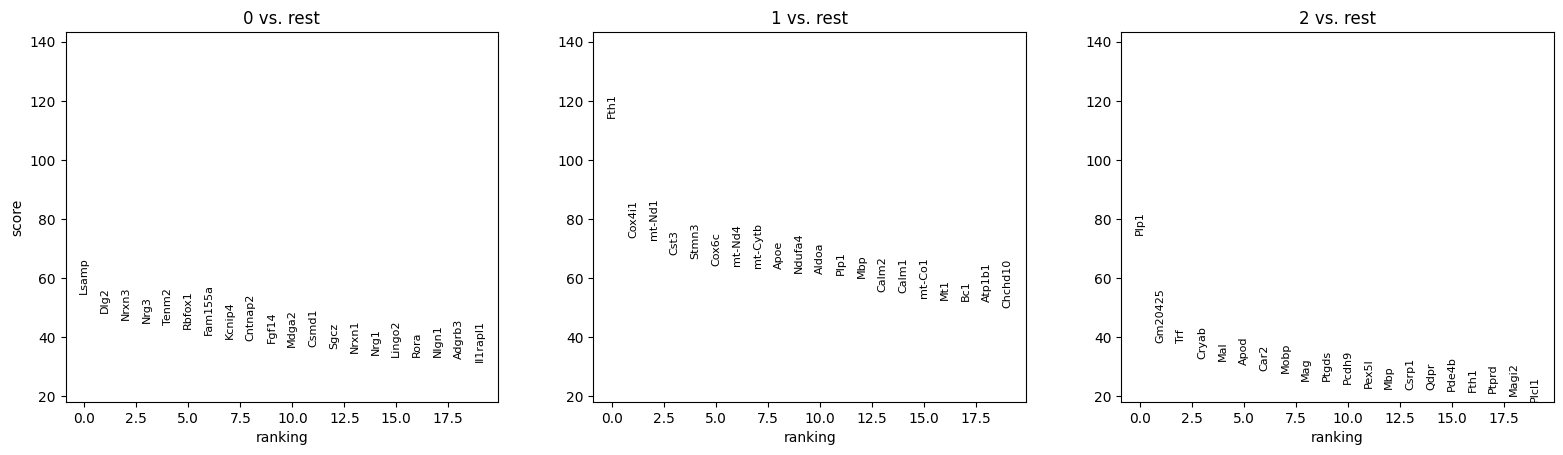

oligo
leiden
0    11371
1     8472
2     7250
3     6725
4      222
dtype: int64


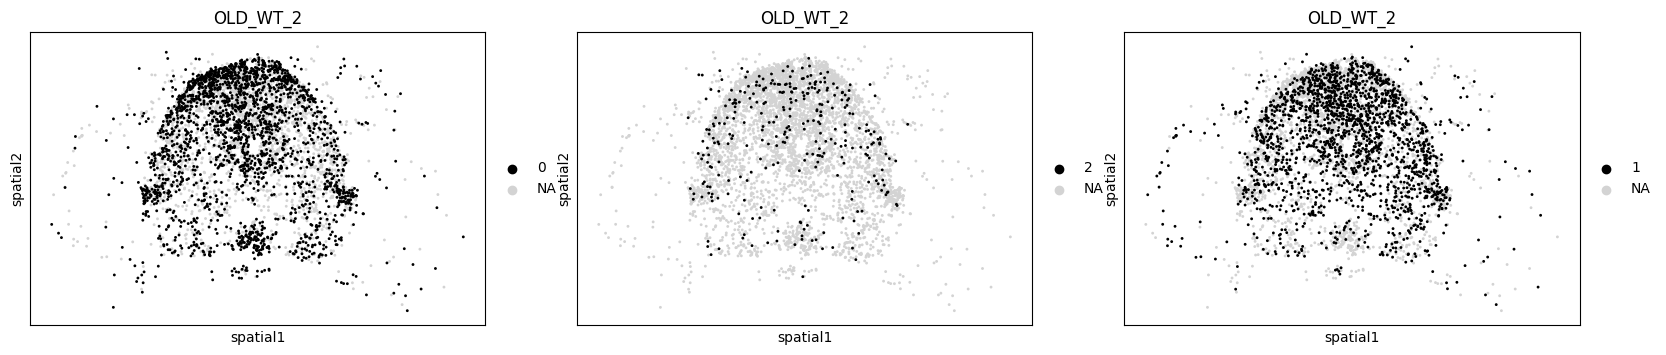

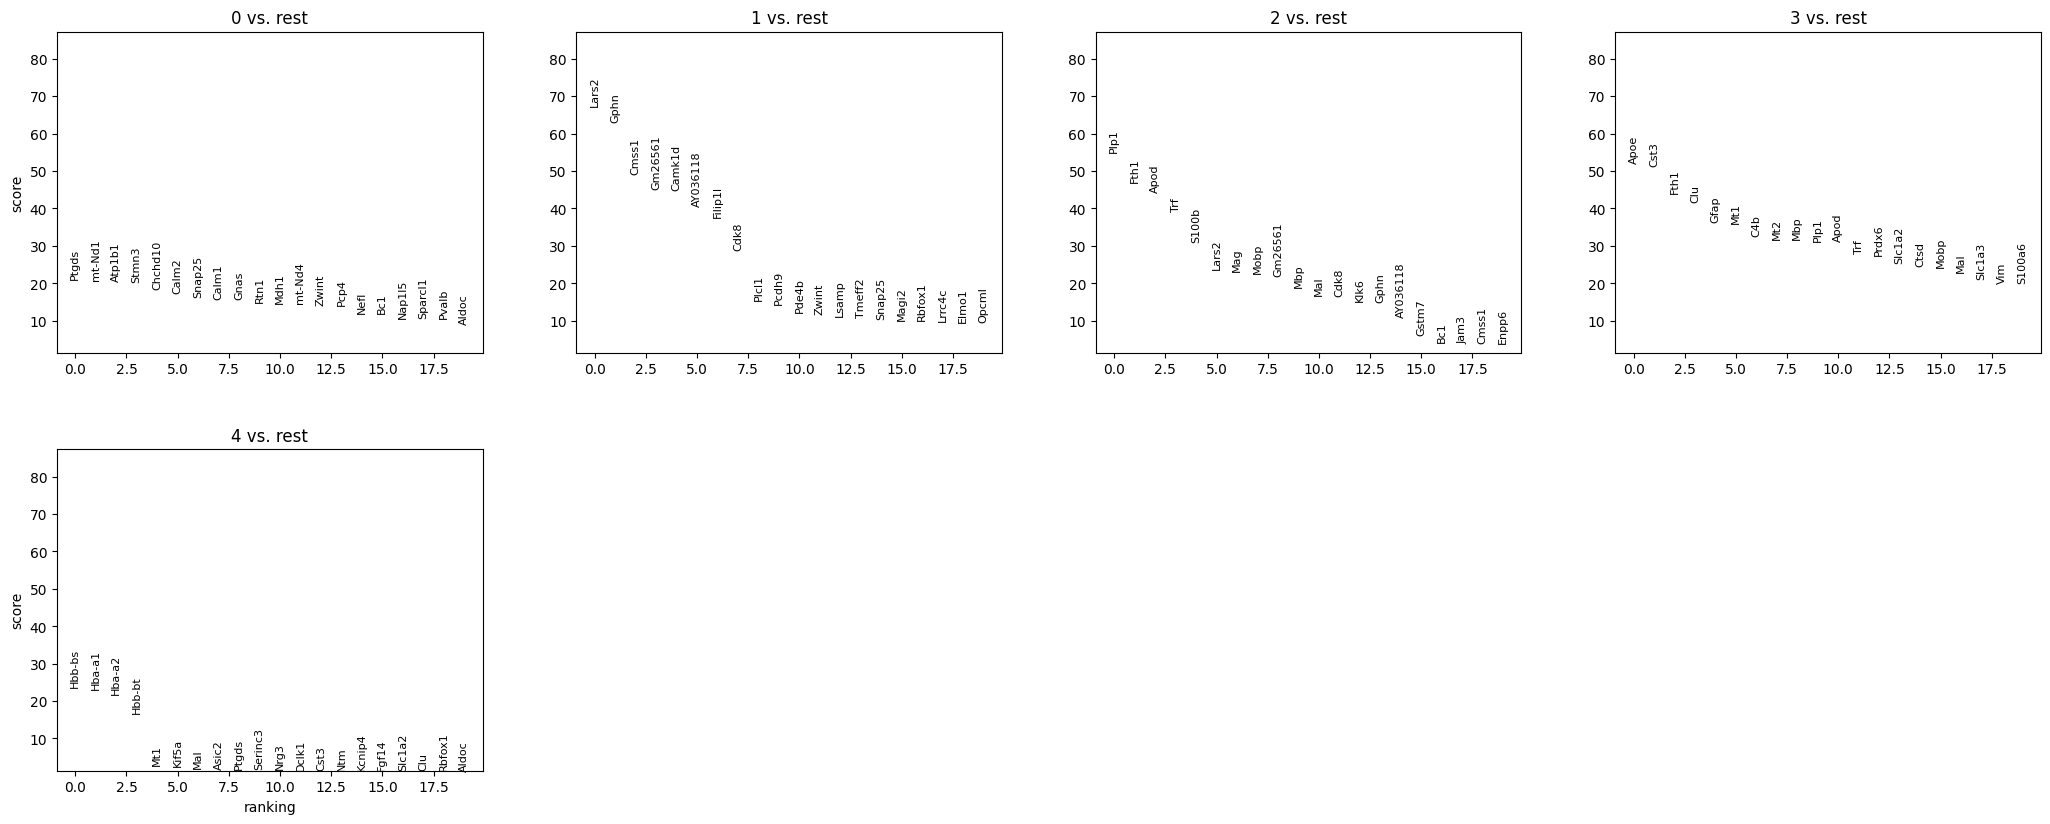

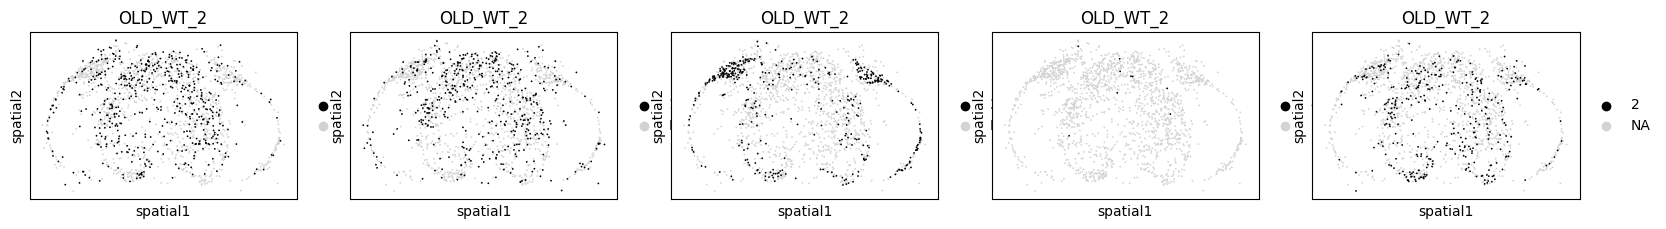

In [100]:
for k,v in d_adata_subset.items():
    print(k)
    plot_the_outcome(v, sample_name='OLD_WT_2')

In [97]:
size_dict = build_size_dict(d_adata_subset)
size_dict

{'midbrainCapsule': {5096: 'text', 36932: 'text', 41346: 'text'},
 'oligo': {222: 'text',
  6725: 'text',
  7250: 'text',
  8472: 'text',
  11371: 'text'}}


leiden res 0.1...
leiden res 0.2...
leiden res 0.30000000000000004...
leiden res 0.4...


In [98]:
adata.obs.groupby('cell_type').size()

cell_type
CA1_CA3                      15681
CA3                          14888
CA3_CA1                      16062
Cartpt                         163
L6                           13310
L6_plp1                      11987
adarb2                        9650
amygdalaVentralSubiculum      8759
astrocytes_group0            17605
astrocytes_group1             9756
cortex                      117041
dentateGyrus                 15197
dopaminergic                  5134
hbb                            417
hbb_2                          624
meninges                      6051
microglia                     3320
midbrainCapsule              83374
oligo                        34040
optic                         1494
pvalb                        10010
sst                          10385
thalamus                      6363
unknown                       3161
dtype: int64

In [110]:
genes = ['Snap25', 'Plp1', 'Hba-a1', 'Tyrobp', 'Adarb2', 'Sst', 'Pvalb', 'Cartpt', 'Th', 'Gad1']
# cts = pd.DataFrame(adata[:, genes].X.A, columns = genes, index=adata.obs_names).join(adata.obs)
cts = pd.DataFrame(d_adata_subset['oligo'][:, genes].X.A, columns = genes, index=d_adata_subset['oligo'].obs_names).join(d_adata_subset['oligo'].obs)

cts.groupby('leiden')[genes].mean()

Snap25      Plp1    Hba-a1    Tyrobp    Adarb2       Sst     Pvalb  \
leiden                                                                         
0       1.928103  5.540665  0.452121  0.356322  0.147862  0.883412  0.709287   
1       1.886908  5.166792  0.326833  0.174256  0.224389  0.915240  0.443865   
2       1.352432  6.370469  0.378389  0.219145  0.153437  0.604586  0.464595   
3       1.168415  6.151625  0.408187  0.683473  0.142837  0.820609  0.269226   
4       1.653361  5.609826  5.537977  0.308719  0.113286  0.881932  0.531953   

          Cartpt        Th      Gad1  
leiden                                
0       0.377252  0.108677  0.470905  
1       0.307800  0.101487  0.430209  
2       0.273609  0.114103  0.237117  
3       0.230106  0.043679  0.208928  
4       0.301269  0.134495  0.380903

In [90]:
labels = ['midbrainOligo', 'midbrainCapsule']

for count, k in enumerate(size_dict['midbrainCapsule'].keys()):
    size_dict['midbrainCapsule'][k] = labels[count]

labels = ['hbb_3', 'oligo']

for count, k in enumerate(size_dict['oligo'].keys()):
    size_dict['oligo'][k] = labels[count]

In [91]:
for k,v in d_adata_subset.items():
    if k in size_dict.keys():
        print(k)
        adata = annotate(adata, v, size_dict[k])

midbrainCapsule
oligo


In [92]:
ignore.append('hbb_2')
ignore.append('microglia')

In [93]:
adata.write_h5ad('backup7.h5ad')

# Decide what will be clustered using GraphST

In [26]:
genes = ['Snap25', 'Plp1', 'Gpc5', 'Tyrobp', 'Mgp', 'Adarb2', 'Sst', 'Pvalb', 'Cartpt', 'Th', 'Gad1', 'Pdgfra']
cts = pd.DataFrame(adata[:, genes].X.A, columns = genes, index=adata.obs_names).join(adata.obs)
cts.groupby('cell_type')[genes].mean()

Snap25       Plp1  \
cell_type                                                                 
astrocytes_diffuse_type0                            0.767572   0.763635   
astrocytes_diffuse_type1                            0.830548   3.266733   
astrocytes_meninges                                 0.534158   0.751932   
astrocytes_unknown                                  0.473282   0.725191   
cortexCA3_CA3                                       4.253468   0.600024   
cortexCA3_group0_group0                             2.686683   0.407269   
cortexCA3_group0_group1                             2.497021   0.480692   
cortexCA3_group1_group0                             2.896894   0.753199   
cortexCA3_group1_group1                             2.953928   1.428431   
cortexCA3_group1_hbb                                3.274157   1.008989   
corticalInterneurons_adarb2                         1.807885   0.641651   
corticalInterneurons_sst_pvalb                      2.614978   0.634208   
corticalInterneurons_sst_sst                        2.268201   0.908030   
dentateGyrus                                        1.878715   0.353148   
midbrainCapsule_dopaminergic_group0                 2.206059   2.532993   
midbrainCapsule_dopaminergic_group1                 2.328571   2.855901   
midbrainCapsule_midbrainCapsule_OPC                 0.749596   2.294727   
midbrainCapsule_midbrainCapsule_cartpt              1.744898   1.887755   
midbrainCapsule_midbrainCapsule_glial_glial         0.610717  14.584444   
midbrainCapsule_midbrainCapsule_glial_neuronalE...  1.390863   7.067134   
midbrainCapsule_midbrainCapsule_microglia           1.299675   2.397404   
midbrainCapsule_midbrainCapsule_neuronal_glialE...  2.072859   4.914580   
midbrainCapsule_midbrainCapsule_neuronal_group0     2.148778   0.890072   
midbrainCapsule_midbrainCapsule_neuronal_group1     2.937959   1.399941   
midbrainCapsule_midbrainCapsule_neuronal_hbb        2.160000   2.936774   
midbrainCapsule_midbrainCapsule_optic               2.231013   1.741139   
midbrainCapsule_thalamic                            2.101971   1.864561   

                                                        Gpc5    Tyrobp  \
cell_type                                                                
astrocytes_diffuse_type0                            2.791261  0.047312   
astrocytes_diffuse_type1                            0.777251  0.163133   
astrocytes_meninges                                 0.188253  0.174034   
astrocytes_unknown                                  0.045802  0.091603   
cortexCA3_CA3                                       0.097104  0.082867   
cortexCA3_group0_group0                             0.074208  0.066836   
cortexCA3_group0_group1                             0.173206  0.067590   
cortexCA3_group1_group0                             0.109798  0.060091   
cortexCA3_group1_group1                             0.077683  0.081961   
cortexCA3_group1_hbb                                0.060674  0.125843   
corticalInterneurons_adarb2                         0.086178  0.066234   
corticalInterneurons_sst_pvalb                      0.072751  0.072039   
corticalInterneurons_sst_sst                        0.082804  0.079158   
dentateGyrus                                        0.065696  0.073010   
midbrainCapsule_dopaminergic_group0                 0.119976  0.127475   
midbrainCapsule_dopaminergic_group1                 0.099379  0.207453   
midbrainCapsule_midbrainCapsule_OPC                 0.953413  0.065351   
midbrainCapsule_midbrainCapsule_cartpt              0.081633  0.229592   
midbrainCapsule_midbrainCapsule_glial_glial         0.075049  0.231757   
midbrainCapsule_midbrainCapsule_glial_neuronalE...  0.071308  0.079309   
midbrainCapsule_midbrainCapsule_microglia           0.093040  1.491886   
midbrainCapsule_midbrainCapsule_neuronal_glialE...  0.217698  0.169445   
midbrainCapsule_midbrainCapsule_neuronal_group0     0.348187  0.074162   
midbrainCapsule_midbrainCaps

In [29]:
# remove midbrainCapsule_midbrainCapsule_neuronal_glialExclude
adata = adata[adata.obs['cell_type'] != 'midbrainCapsule_midbrainCapsule_neuronal_glialExclude', :].copy()

In [30]:
non_spatial = ['astrocytes_diffuse_type0', 'astrocytes_diffuse_type1', 
 'astrocytes_diffuse_meninges', 'astrocytes_unknown',
 'corticalInterneurons_adarb2', 'corticalInterneurons_sst_pvalb', 'corticalInterneurons_sst_sst',
 'cortexCA3_group1_hbb',
 'midbrainCapsule_midbrainCapsule_OPC', 
 'midbrainCapsule_midbrainCapsule_cartpt',
 'midbrainCapsule_midbrainCapsule_glial_glial',
 'midbrainCapsule_midbrainCapsule_microglia',
 'midbrainCapsule_midbrainCapsule_neuronal_hbb']
 

In [31]:
adata_gst = adata[~adata.obs['cell_type'].isin(non_spatial), :].copy()

In [32]:
adata_gst.write_h5ad('input/04_cluster/adata_gst.h5ad')

In [36]:
adata_nongst = adata[adata.obs['cell_type'].isin(non_spatial), :].copy()
adata_nongst.write_h5ad('input/04_cluster/adata_nongst.h5ad')

# Load GraphST

In [106]:
adata_gst = sc.read_h5ad('input/04_cluster/OLD_OVX_1_35clust_GraphST.h5ad')
adata_gst

AnnData object with n_obs × n_vars = 26128 × 14494
    obs: 'area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'outlier', 'x', 'y', 'sample_name', 'sample_id', 'mouse', 'age', 'genotype', 'batch', 'group_n', 'keep', 'x_orig', 'y_orig', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'sample_name_colors'
    obsm: 'adj', 'emb', 'emb_pca', 'feat', 'feat_a', 'graph_neigh', 'label_CSL', 'spatial'
    layers: 'counts'

In [108]:
adata_gst.obs.groupby('domain').size()

domain
1      442
2      936
3      297
4      398
5      914
6     1221
7      848
8      567
9     1244
10     315
11     314
12     587
13     639
14     410
15     178
16     864
17    1125
18     715
19     986
20     637
21    2029
22    1688
23     193
24     969
25     433
26     641
27     950
28     594
29     942
30     658
31     475
32    1002
33     955
34     803
35     159
dtype: int64

In [111]:
v = adata[adata.obs['sample_name'] == 'OLD_OVX_1', :].copy()
v.obs.groupby('cell_type').size()

cell_type
astrocytes_diffuse_type0                                 1425
astrocytes_diffuse_type1                                  682
astrocytes_meninges                                       492
astrocytes_unknown                                          1
cortexCA3_CA3                                             432
cortexCA3_group0_group0                                  3027
cortexCA3_group0_group1                                  1950
cortexCA3_group1_group0                                  3789
cortexCA3_group1_group1                                  1188
cortexCA3_group1_hbb                                        6
corticalInterneurons_adarb2                               713
corticalInterneurons_sst                                 1170
dentateGyrus                                              821
midbrainCapsule_dopaminergic_group0                       299
midbrainCapsule_dopaminergic_group1                        57
midbrainCapsule_midbrainCapsule_OPC                       31

In [114]:
ct_d = v.obs['cell_type'].to_dict()

In [116]:
adata_gst.obs['cell_type'] = 'unknown'
adata_gst.obs['cell_type'].update(ct_d)

In [122]:
adata_gst.obs.groupby(['cell_type', 'domain']).size().reset_index().to_csv("test.csv")

# Single

In [ ]:
model = GraphST.GraphST(adata, datatype='Stereo', device=device)
adata = model.train()

In [ ]:
# clustering

n_clusters = 20
tool = 'mclust' # mclust, leiden, and louvain

if tool == 'mclust':
   clustering(adata, n_clusters, method=tool)
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, method=tool, start=0.1, end=2.0, increment=0.1)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8*1,6))
sc.pl.spatial(adata, color='domain', spot_size=80, show=False, ax=ax)
ax.invert_yaxis()

# All

In [ ]:
for k,v in d_adata.items():
    print(k)
    # sc.pp.subsample(v, n_obs=1000)
    model = GraphST.GraphST(v, datatype='Stereo', device=device)
    v = model.train()
    clustering(v, n_clusters=35, method='mclust')
    v.write_h5ad('input/04_cluster/' + k + '_35clust_GraphST.h5ad')
    # d_adata[k] = v.copy()

In [ ]:
d = {x.split('/')[-1].split('_35clust_GraphST.h5ad')[0]:x for x in glob.glob('input/04_cluster/*h5ad', recursive=True)}
d

In [ ]:
d_adata = {}
for k,v in d.items():
    print(k)
    d_adata[k] = sc.read_h5ad(v)

In [ ]:
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
           "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
          "#877F6C","#268785", '#82EF2D', '#B4EEB4', 'darkgreen', 'red', 'purple']

d_adata = {}

for k in d_adata.keys():
    adata = sc.read_h5ad('input/04_cluster/' + k + '_35clust_GraphST.h5ad')
    if 'domain' in adata.obs.columns:
        fig, ax = plt.subplots(1,1,figsize=(8*1,6))
        sc.pl.spatial(adata, color='domain', spot_size=80, 
                      palette=plot_color,
                      show=False, ax=ax)
        ax.invert_yaxis()

In [ ]:
d_adata = {}

for k in d_adata.keys():
    adata = sc.read_h5ad('input/04_cluster/' + k + '_35clust_GraphST.h5ad')

In [ ]:
def plot_all_spatial(k):

    adata = d_adata[k].copy()
    
    adata.obs['domain'] = adata.obs['domain'].astype('str')
    domains = sorted(adata.obs['domain'].astype('int').unique())
    
    fig, axs = plt.subplots(nrows=7, ncols=5, figsize=(35, 25))

    row = 0
    for dom in tqdm(domains):
        # print('Domain: ' + str(dom))
        if dom % 5 == 0:
            col = 4
        else:
            col = (dom % 5) - 1

        # print('Row: ' + str(row))
        # print('Column: ' + str(col))
        # for col, section in enumerate(adata.obs.sample_name.unique()):

        sc.pl.spatial(adata, 
                     spot_size=25, 
                      size = 5,
                      groups = str(dom),
                     color = 'domain', 
                      palette = ['black' for x in domains],
                     ax=axs[row, col], 
                      title = str(dom),
                     show=False)
        plt.suptitle(k, y = 1.05)

        if dom % 5 == 0:
            row += 1

In [ ]:
for k in tqdm(d_adata.keys()):
    plot_all_spatial(k)

In [ ]:
1

In [ ]:
# import matplotlib.pyplot as plt
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (8, 6)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
           "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
           "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
          "#877F6C","#268785", '#82EF2D', '#B4EEB4']

ax = sc.pl.embedding(adata, basis="spatial",
                    color="domain",
                    s=10,
                    show=False,
                    palette=plot_color,
                    title='GraphST')
ax.axis('off')
ax.set_title('Mouse Embryo E9.5')
ax.invert_yaxis()

In [ ]:
# adata = adata[adata.obs['sample_id'] == 'D01066F5', :].copy()
# sc.pp.subsample(adata, n_obs=5000)
adata = init_adata(adata, norm_log=False)

slices = []
for count, x in enumerate(adata.obs['sample_name'].unique()):
    if count > 2:
        break
    y = adata[adata.obs['sample_name'] == x,].copy()
    sc.pp.subsample(y, n_obs=10000)

    sc.pp.filter_genes(y, min_counts = 15)
    sc.pp.filter_cells(y, min_counts = 100)
    sc.pp.highly_variable_genes(
    y,
    n_top_genes=1000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="sample_name"
    # span = 1
    )
    y.X = y.X.A.astype('float32')
    print(y.shape)
    slices.append(y.copy())

initial_slice = slices[0].copy()
lmbda = len(slices)*[1/len(slices)]
del adata

In [ ]:
pst.filter_for_common_genes(slices)

b = []
for i in range(len(slices)):
    b.append(pst.match_spots_using_spatial_heuristic(slices[0].X, slices[i].X))

In [ ]:
center_slice, pis = pst.center_align(initial_slice, slices, lmbda, 
                                     max_iter = 200,
                                     
                                     # backend = ot.backend.TorchBackend(), 
                                     # use_gpu = True,
                                     random_seed = 42)

In [ ]:
center, new_slices = pst.stack_slices_center(center_slice, slices, pis)

In [ ]:
pst.plot_slice(center, center_color, s = 50)

In [ ]:
pst.plot_slice(new_slices[0], slices_colors[0], s = 50)

In [ ]:
i=1
pst.plot_slice(new_slices[i], slices_colors[i], s = 50)

In [ ]:
i=2
pst.plot_slice(new_slices[i], slices_colors[i], s = 50)

In [ ]:
i=3
pst.plot_slice(new_slices[i], slices_colors[i], s = 50)

In [ ]:
center_color = 'orange'
slices_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

plt.figure(figsize=(10,10))
pst.plot_slice(center,center_color,s=50)
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slices_colors[i],s=50)

plt.legend(handles=[mpatches.Patch(color=slices_colors[0], label='1'),mpatches.Patch(color=slices_colors[1], label='2'),mpatches.Patch(color=slices_colors[2], label='3'),mpatches.Patch(color=slices_colors[3], label='4')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [ ]:
pst.filter_for_common_genes(slices)

b = []
for i in range(len(slices)):
    b.append(pst.match_spots_using_spatial_heuristic(slices[0].X, slices[i].X))

In [ ]:
pst.filter_for_common_genes(slices)

b = Parallel(n_jobs=len(slices))(delayed(pst.match_spots_using_spatial_heuristic)(slices[0].X, slices[i].X) for i in range(len(slices)))

In [ ]:
start = time.time()

pi12 = pst.pairwise_align(d_adata['OLD_OVX_1'], d_adata['OLD_OVX_2'], 
                          backend = ot.backend.TorchBackend(), use_gpu = True, numItermax=1000)
# pi12 = pst.pairwise_align(d_adata['OLD_OVX_1'], d_adata['OLD_OVX_2'], numItermax=1000)
# pi23 = pst.pairwise_align(slice2, slice3, backend = ot.backend.TorchBackend(), use_gpu = True)
# pi34 = pst.pairwise_align(slice3, slice4, backend = ot.backend.TorchBackend(), use_gpu = True)

print('Runtime: ' + str(time.time() - start))

In [ ]:
pi12

# GraphST